In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
import pickle
import gzip

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_OF.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
42373,winKen_wave_u_cm_np1_ri_bad_1_flow6.jpg,wave
42374,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42375,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42376,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave
42377,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame_OF/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 42378/42378 [02:46<00:00, 254.12it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)
train_image=[]
# shape of the array
print(X_train.shape)
print(X_train.max())

(42378, 224, 224, 3)
1.0


In [5]:
val = pd.read_csv('../data/val_OF.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
8798,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8799,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8800,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8801,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8802,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame_OF/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 8803/8803 [00:42<00:00, 209.09it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)
val_image=[]
# shape of the array
print(X_test.shape)
print(X_test.max())

(8803, 224, 224, 3)
1.0


In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    21189
class       51
dtype: int64
image    8803
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(42378, 51)
(8803, 51)


In [10]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [11]:
print(base_model.output_shape)

(None, None, None, 2048)


In [12]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

In [13]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

In [ ]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2-t1)

In [ ]:
X_train = X_train.reshape(42378, 7*7*2048)
print(type(X_train))

In [ ]:
X_train = X_train/255
print(X_train.shape)

In [ ]:
pickle_out = open('../Pickle/ResNet101V2_X_train_OF.pickle',"wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

In [14]:
pickle_in = open('../Pickle/ResNet101V2_X_train_OF.pickle',"rb")
X_train = pickle.load(pickle_in)
print(X_train.shape)

(42378, 100352)


In [ ]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4-t3)

In [13]:
X_test = X_test.reshape(8803, 7*7*2048)

In [14]:
X_test = X_test/255
print(X_test.shape)

(8803, 100352)


In [15]:
joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_OF.pkl')

['../Pickle/ResNet101V2_X_test_OF.pkl']

In [15]:
X_test=[]
X_test = joblib.load('../Pickle/ResNet101V2_X_test_OF.pkl') 
print(X_test.shape)

(8803, 100352)


In [16]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42378, 100352)
(8803, 100352)
(42378, 51)
(8803, 51)


In [17]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [18]:
model.output_shape

(None, 51)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [20]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 100352),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_init

In [21]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_OF.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [22]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [23]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6-t5)

2020-08-31 13:47:30.967998
Train on 42378 samples, validate on 8803 samples
Epoch 1/100
23424/42378 [===============>..............] - ETA: 35:58 - loss: 3.9324 - accuracy: 0.023 - ETA: 22:31 - loss: 3.9338 - accuracy: 0.023 - ETA: 18:08 - loss: 3.9351 - accuracy: 0.028 - ETA: 15:18 - loss: 3.9335 - accuracy: 0.027 - ETA: 13:35 - loss: 3.9316 - accuracy: 0.029 - ETA: 12:24 - loss: 3.9350 - accuracy: 0.028 - ETA: 11:36 - loss: 3.9315 - accuracy: 0.025 - ETA: 11:00 - loss: 3.9289 - accuracy: 0.026 - ETA: 10:29 - loss: 3.9282 - accuracy: 0.025 - ETA: 10:07 - loss: 3.9251 - accuracy: 0.027 - ETA: 9:48 - loss: 3.9272 - accuracy: 0.026 - ETA: 9:32 - loss: 3.9245 - accuracy: 0.02 - ETA: 9:17 - loss: 3.9216 - accuracy: 0.02 - ETA: 9:04 - loss: 3.9197 - accuracy: 0.02 - ETA: 8:50 - loss: 3.9211 - accuracy: 0.02 - ETA: 8:39 - loss: 3.9137 - accuracy: 0.02 - ETA: 8:29 - loss: 3.9158 - accuracy: 0.02 - ETA: 8:20 - loss: 3.9131 - accuracy: 0.02 - ETA: 8:11 - loss: 3.9111 - accuracy: 0.02 - ETA: 8:0

23680/42378 [===============>..............] - ETA: 27:30 - loss: 3.0266 - accuracy: 0.265 - ETA: 18:38 - loss: 3.0930 - accuracy: 0.226 - ETA: 14:55 - loss: 3.0306 - accuracy: 0.234 - ETA: 12:59 - loss: 3.0376 - accuracy: 0.226 - ETA: 11:54 - loss: 3.0046 - accuracy: 0.237 - ETA: 11:05 - loss: 2.9959 - accuracy: 0.237 - ETA: 10:35 - loss: 2.9777 - accuracy: 0.244 - ETA: 10:10 - loss: 2.9613 - accuracy: 0.250 - ETA: 9:49 - loss: 2.9684 - accuracy: 0.244 - ETA: 9:31 - loss: 2.9327 - accuracy: 0.25 - ETA: 9:18 - loss: 2.9324 - accuracy: 0.25 - ETA: 9:06 - loss: 2.9404 - accuracy: 0.25 - ETA: 8:53 - loss: 2.9536 - accuracy: 0.25 - ETA: 8:43 - loss: 2.9436 - accuracy: 0.25 - ETA: 8:34 - loss: 2.9360 - accuracy: 0.25 - ETA: 8:40 - loss: 2.9316 - accuracy: 0.25 - ETA: 8:32 - loss: 2.9348 - accuracy: 0.26 - ETA: 8:25 - loss: 2.9256 - accuracy: 0.26 - ETA: 8:20 - loss: 2.9076 - accuracy: 0.26 - ETA: 8:15 - loss: 2.9028 - accuracy: 0.26 - ETA: 8:07 - loss: 2.8996 - accuracy: 0.26 - ETA: 8:01 - 

42378/42378 [==============================] - ETA: 3:23 - loss: 2.6962 - accuracy: 0.30 - ETA: 3:21 - loss: 2.6950 - accuracy: 0.30 - ETA: 3:20 - loss: 2.6931 - accuracy: 0.30 - ETA: 3:19 - loss: 2.6927 - accuracy: 0.30 - ETA: 3:17 - loss: 2.6915 - accuracy: 0.30 - ETA: 3:16 - loss: 2.6904 - accuracy: 0.30 - ETA: 3:15 - loss: 2.6889 - accuracy: 0.30 - ETA: 3:14 - loss: 2.6882 - accuracy: 0.30 - ETA: 3:12 - loss: 2.6876 - accuracy: 0.30 - ETA: 3:11 - loss: 2.6856 - accuracy: 0.30 - ETA: 3:09 - loss: 2.6840 - accuracy: 0.30 - ETA: 3:08 - loss: 2.6819 - accuracy: 0.30 - ETA: 3:07 - loss: 2.6805 - accuracy: 0.30 - ETA: 3:05 - loss: 2.6796 - accuracy: 0.30 - ETA: 3:04 - loss: 2.6789 - accuracy: 0.30 - ETA: 3:02 - loss: 2.6783 - accuracy: 0.30 - ETA: 3:01 - loss: 2.6766 - accuracy: 0.31 - ETA: 3:00 - loss: 2.6741 - accuracy: 0.31 - ETA: 2:59 - loss: 2.6749 - accuracy: 0.31 - ETA: 2:57 - loss: 2.6749 - accuracy: 0.31 - ETA: 2:56 - loss: 2.6751 - accuracy: 0.31 - ETA: 2:54 - loss: 2.6739 - ac

23808/42378 [===============>..............] - ETA: 10:13 - loss: 1.5802 - accuracy: 0.546 - ETA: 10:46 - loss: 1.6008 - accuracy: 0.519 - ETA: 9:56 - loss: 1.5204 - accuracy: 0.554 - ETA: 9:29 - loss: 1.5971 - accuracy: 0.54 - ETA: 9:07 - loss: 1.6770 - accuracy: 0.52 - ETA: 9:02 - loss: 1.6930 - accuracy: 0.51 - ETA: 9:04 - loss: 1.7076 - accuracy: 0.51 - ETA: 8:57 - loss: 1.7219 - accuracy: 0.51 - ETA: 8:50 - loss: 1.7360 - accuracy: 0.50 - ETA: 8:59 - loss: 1.7166 - accuracy: 0.51 - ETA: 8:56 - loss: 1.7055 - accuracy: 0.51 - ETA: 8:52 - loss: 1.7135 - accuracy: 0.51 - ETA: 8:48 - loss: 1.7114 - accuracy: 0.51 - ETA: 8:48 - loss: 1.7027 - accuracy: 0.51 - ETA: 8:44 - loss: 1.6973 - accuracy: 0.52 - ETA: 8:39 - loss: 1.6873 - accuracy: 0.52 - ETA: 8:35 - loss: 1.6961 - accuracy: 0.52 - ETA: 8:30 - loss: 1.6815 - accuracy: 0.52 - ETA: 8:26 - loss: 1.6774 - accuracy: 0.52 - ETA: 8:22 - loss: 1.6750 - accuracy: 0.52 - ETA: 8:20 - loss: 1.6673 - accuracy: 0.52 - ETA: 8:17 - loss: 1.6745

42378/42378 [==============================] - ETA: 3:47 - loss: 1.5716 - accuracy: 0.55 - ETA: 3:45 - loss: 1.5724 - accuracy: 0.55 - ETA: 3:43 - loss: 1.5711 - accuracy: 0.55 - ETA: 3:42 - loss: 1.5696 - accuracy: 0.55 - ETA: 3:40 - loss: 1.5697 - accuracy: 0.55 - ETA: 3:38 - loss: 1.5684 - accuracy: 0.55 - ETA: 3:36 - loss: 1.5683 - accuracy: 0.55 - ETA: 3:35 - loss: 1.5681 - accuracy: 0.55 - ETA: 3:33 - loss: 1.5681 - accuracy: 0.55 - ETA: 3:31 - loss: 1.5668 - accuracy: 0.55 - ETA: 3:29 - loss: 1.5645 - accuracy: 0.55 - ETA: 3:28 - loss: 1.5646 - accuracy: 0.55 - ETA: 3:26 - loss: 1.5649 - accuracy: 0.55 - ETA: 3:24 - loss: 1.5645 - accuracy: 0.55 - ETA: 3:23 - loss: 1.5643 - accuracy: 0.55 - ETA: 3:21 - loss: 1.5635 - accuracy: 0.55 - ETA: 3:19 - loss: 1.5619 - accuracy: 0.55 - ETA: 3:17 - loss: 1.5620 - accuracy: 0.55 - ETA: 3:16 - loss: 1.5614 - accuracy: 0.55 - ETA: 3:15 - loss: 1.5607 - accuracy: 0.55 - ETA: 3:13 - loss: 1.5609 - accuracy: 0.55 - ETA: 3:11 - loss: 1.5599 - ac

23680/42378 [===============>..............] - ETA: 45:17 - loss: 0.9100 - accuracy: 0.757 - ETA: 26:22 - loss: 1.0362 - accuracy: 0.722 - ETA: 20:01 - loss: 0.9819 - accuracy: 0.724 - ETA: 16:57 - loss: 1.0380 - accuracy: 0.697 - ETA: 14:59 - loss: 1.0393 - accuracy: 0.703 - ETA: 13:37 - loss: 1.0628 - accuracy: 0.692 - ETA: 12:39 - loss: 1.0671 - accuracy: 0.687 - ETA: 11:54 - loss: 1.0594 - accuracy: 0.687 - ETA: 11:19 - loss: 1.0708 - accuracy: 0.687 - ETA: 10:54 - loss: 1.0705 - accuracy: 0.685 - ETA: 10:33 - loss: 1.1009 - accuracy: 0.679 - ETA: 10:13 - loss: 1.1090 - accuracy: 0.676 - ETA: 9:55 - loss: 1.1212 - accuracy: 0.674 - ETA: 9:39 - loss: 1.1422 - accuracy: 0.66 - ETA: 9:26 - loss: 1.1476 - accuracy: 0.66 - ETA: 9:15 - loss: 1.1538 - accuracy: 0.66 - ETA: 9:05 - loss: 1.1550 - accuracy: 0.66 - ETA: 8:56 - loss: 1.1541 - accuracy: 0.66 - ETA: 8:49 - loss: 1.1615 - accuracy: 0.66 - ETA: 8:42 - loss: 1.1619 - accuracy: 0.66 - ETA: 8:36 - loss: 1.1573 - accuracy: 0.66 - ETA:

42378/42378 [==============================] - ETA: 3:27 - loss: 1.0807 - accuracy: 0.67 - ETA: 3:25 - loss: 1.0795 - accuracy: 0.67 - ETA: 3:24 - loss: 1.0788 - accuracy: 0.67 - ETA: 3:22 - loss: 1.0779 - accuracy: 0.67 - ETA: 3:21 - loss: 1.0780 - accuracy: 0.67 - ETA: 3:19 - loss: 1.0785 - accuracy: 0.67 - ETA: 3:18 - loss: 1.0786 - accuracy: 0.67 - ETA: 3:17 - loss: 1.0780 - accuracy: 0.67 - ETA: 3:15 - loss: 1.0780 - accuracy: 0.67 - ETA: 3:14 - loss: 1.0778 - accuracy: 0.67 - ETA: 3:12 - loss: 1.0765 - accuracy: 0.67 - ETA: 3:11 - loss: 1.0760 - accuracy: 0.67 - ETA: 3:10 - loss: 1.0761 - accuracy: 0.67 - ETA: 3:08 - loss: 1.0756 - accuracy: 0.67 - ETA: 3:07 - loss: 1.0759 - accuracy: 0.67 - ETA: 3:05 - loss: 1.0753 - accuracy: 0.67 - ETA: 3:04 - loss: 1.0766 - accuracy: 0.67 - ETA: 3:02 - loss: 1.0762 - accuracy: 0.67 - ETA: 3:01 - loss: 1.0761 - accuracy: 0.67 - ETA: 2:59 - loss: 1.0762 - accuracy: 0.67 - ETA: 2:58 - loss: 1.0755 - accuracy: 0.67 - ETA: 2:56 - loss: 1.0747 - ac

23808/42378 [===============>..............] - ETA: 8:51 - loss: 0.7368 - accuracy: 0.78 - ETA: 7:50 - loss: 0.8797 - accuracy: 0.71 - ETA: 7:30 - loss: 0.8450 - accuracy: 0.72 - ETA: 7:20 - loss: 0.8595 - accuracy: 0.73 - ETA: 7:23 - loss: 0.9034 - accuracy: 0.72 - ETA: 7:24 - loss: 0.9043 - accuracy: 0.72 - ETA: 7:16 - loss: 0.9012 - accuracy: 0.72 - ETA: 7:15 - loss: 0.8895 - accuracy: 0.72 - ETA: 7:13 - loss: 0.9022 - accuracy: 0.72 - ETA: 7:08 - loss: 0.9284 - accuracy: 0.71 - ETA: 7:05 - loss: 0.9406 - accuracy: 0.71 - ETA: 7:04 - loss: 0.9439 - accuracy: 0.71 - ETA: 7:01 - loss: 0.9410 - accuracy: 0.71 - ETA: 7:09 - loss: 0.9235 - accuracy: 0.71 - ETA: 7:06 - loss: 0.9125 - accuracy: 0.72 - ETA: 7:02 - loss: 0.9129 - accuracy: 0.72 - ETA: 6:59 - loss: 0.9029 - accuracy: 0.72 - ETA: 6:57 - loss: 0.9029 - accuracy: 0.72 - ETA: 6:55 - loss: 0.8844 - accuracy: 0.72 - ETA: 6:54 - loss: 0.8973 - accuracy: 0.72 - ETA: 6:57 - loss: 0.8936 - accuracy: 0.72 - ETA: 6:55 - loss: 0.8906 - ac

42378/42378 [==============================] - ETA: 3:08 - loss: 0.8175 - accuracy: 0.74 - ETA: 3:07 - loss: 0.8177 - accuracy: 0.74 - ETA: 3:06 - loss: 0.8176 - accuracy: 0.75 - ETA: 3:04 - loss: 0.8169 - accuracy: 0.75 - ETA: 3:03 - loss: 0.8161 - accuracy: 0.75 - ETA: 3:02 - loss: 0.8160 - accuracy: 0.75 - ETA: 3:01 - loss: 0.8165 - accuracy: 0.75 - ETA: 3:00 - loss: 0.8164 - accuracy: 0.75 - ETA: 2:59 - loss: 0.8164 - accuracy: 0.75 - ETA: 2:57 - loss: 0.8167 - accuracy: 0.75 - ETA: 2:56 - loss: 0.8165 - accuracy: 0.75 - ETA: 2:55 - loss: 0.8165 - accuracy: 0.75 - ETA: 2:53 - loss: 0.8161 - accuracy: 0.75 - ETA: 2:52 - loss: 0.8167 - accuracy: 0.75 - ETA: 2:51 - loss: 0.8164 - accuracy: 0.75 - ETA: 2:50 - loss: 0.8152 - accuracy: 0.75 - ETA: 2:48 - loss: 0.8155 - accuracy: 0.75 - ETA: 2:47 - loss: 0.8161 - accuracy: 0.75 - ETA: 2:46 - loss: 0.8160 - accuracy: 0.75 - ETA: 2:44 - loss: 0.8165 - accuracy: 0.75 - ETA: 2:43 - loss: 0.8161 - accuracy: 0.75 - ETA: 2:42 - loss: 0.8155 - ac

22784/42378 [===============>..............] - ETA: 42:03 - loss: 0.5135 - accuracy: 0.851 - ETA: 38:28 - loss: 0.6113 - accuracy: 0.832 - ETA: 40:19 - loss: 0.6217 - accuracy: 0.828 - ETA: 39:11 - loss: 0.6395 - accuracy: 0.816 - ETA: 38:52 - loss: 0.6380 - accuracy: 0.804 - ETA: 37:58 - loss: 0.6579 - accuracy: 0.796 - ETA: 37:09 - loss: 0.6474 - accuracy: 0.800 - ETA: 36:13 - loss: 0.6432 - accuracy: 0.799 - ETA: 36:14 - loss: 0.6393 - accuracy: 0.800 - ETA: 36:20 - loss: 0.6332 - accuracy: 0.802 - ETA: 36:33 - loss: 0.6138 - accuracy: 0.806 - ETA: 37:07 - loss: 0.6122 - accuracy: 0.806 - ETA: 36:42 - loss: 0.6150 - accuracy: 0.807 - ETA: 36:33 - loss: 0.6209 - accuracy: 0.804 - ETA: 36:25 - loss: 0.6333 - accuracy: 0.801 - ETA: 36:30 - loss: 0.6258 - accuracy: 0.803 - ETA: 37:08 - loss: 0.6338 - accuracy: 0.804 - ETA: 37:08 - loss: 0.6315 - accuracy: 0.805 - ETA: 37:20 - loss: 0.6297 - accuracy: 0.805 - ETA: 37:43 - loss: 0.6338 - accuracy: 0.805 - ETA: 37:47 - loss: 0.6396 - accur

42378/42378 [==============================] - ETA: 30:47 - loss: 0.6504 - accuracy: 0.804 - ETA: 30:33 - loss: 0.6497 - accuracy: 0.804 - ETA: 30:22 - loss: 0.6491 - accuracy: 0.805 - ETA: 30:14 - loss: 0.6506 - accuracy: 0.804 - ETA: 30:01 - loss: 0.6503 - accuracy: 0.805 - ETA: 29:49 - loss: 0.6520 - accuracy: 0.804 - ETA: 29:32 - loss: 0.6518 - accuracy: 0.804 - ETA: 29:23 - loss: 0.6524 - accuracy: 0.804 - ETA: 29:11 - loss: 0.6520 - accuracy: 0.804 - ETA: 28:56 - loss: 0.6523 - accuracy: 0.804 - ETA: 28:44 - loss: 0.6520 - accuracy: 0.804 - ETA: 28:33 - loss: 0.6523 - accuracy: 0.804 - ETA: 28:27 - loss: 0.6524 - accuracy: 0.804 - ETA: 28:15 - loss: 0.6525 - accuracy: 0.805 - ETA: 28:02 - loss: 0.6523 - accuracy: 0.804 - ETA: 27:47 - loss: 0.6522 - accuracy: 0.805 - ETA: 27:35 - loss: 0.6537 - accuracy: 0.804 - ETA: 27:25 - loss: 0.6536 - accuracy: 0.804 - ETA: 27:12 - loss: 0.6534 - accuracy: 0.804 - ETA: 26:58 - loss: 0.6531 - accuracy: 0.805 - ETA: 26:45 - loss: 0.6528 - accur

23680/42378 [===============>..............] - ETA: 10:47 - loss: 0.6620 - accuracy: 0.820 - ETA: 10:27 - loss: 0.6838 - accuracy: 0.800 - ETA: 10:19 - loss: 0.6337 - accuracy: 0.817 - ETA: 10:09 - loss: 0.5779 - accuracy: 0.835 - ETA: 10:17 - loss: 0.5963 - accuracy: 0.829 - ETA: 10:10 - loss: 0.5731 - accuracy: 0.833 - ETA: 10:07 - loss: 0.5515 - accuracy: 0.841 - ETA: 10:06 - loss: 0.5438 - accuracy: 0.837 - ETA: 10:05 - loss: 0.5390 - accuracy: 0.838 - ETA: 10:02 - loss: 0.5293 - accuracy: 0.843 - ETA: 9:57 - loss: 0.5237 - accuracy: 0.847 - ETA: 9:56 - loss: 0.5320 - accuracy: 0.84 - ETA: 9:53 - loss: 0.5263 - accuracy: 0.84 - ETA: 9:53 - loss: 0.5314 - accuracy: 0.84 - ETA: 9:53 - loss: 0.5249 - accuracy: 0.84 - ETA: 9:49 - loss: 0.5199 - accuracy: 0.84 - ETA: 9:46 - loss: 0.5315 - accuracy: 0.84 - ETA: 9:44 - loss: 0.5338 - accuracy: 0.84 - ETA: 9:41 - loss: 0.5396 - accuracy: 0.84 - ETA: 9:38 - loss: 0.5311 - accuracy: 0.84 - ETA: 9:36 - loss: 0.5408 - accuracy: 0.84 - ETA: 9:3

42378/42378 [==============================] - ETA: 4:32 - loss: 0.5606 - accuracy: 0.83 - ETA: 4:30 - loss: 0.5604 - accuracy: 0.83 - ETA: 4:29 - loss: 0.5607 - accuracy: 0.83 - ETA: 4:27 - loss: 0.5609 - accuracy: 0.83 - ETA: 4:25 - loss: 0.5606 - accuracy: 0.83 - ETA: 4:23 - loss: 0.5607 - accuracy: 0.83 - ETA: 4:21 - loss: 0.5617 - accuracy: 0.83 - ETA: 4:19 - loss: 0.5613 - accuracy: 0.83 - ETA: 4:17 - loss: 0.5606 - accuracy: 0.83 - ETA: 4:16 - loss: 0.5613 - accuracy: 0.83 - ETA: 4:14 - loss: 0.5616 - accuracy: 0.83 - ETA: 4:12 - loss: 0.5607 - accuracy: 0.83 - ETA: 4:10 - loss: 0.5607 - accuracy: 0.83 - ETA: 4:08 - loss: 0.5599 - accuracy: 0.83 - ETA: 4:06 - loss: 0.5599 - accuracy: 0.83 - ETA: 4:04 - loss: 0.5596 - accuracy: 0.83 - ETA: 4:02 - loss: 0.5581 - accuracy: 0.83 - ETA: 4:01 - loss: 0.5580 - accuracy: 0.83 - ETA: 3:59 - loss: 0.5574 - accuracy: 0.83 - ETA: 3:57 - loss: 0.5572 - accuracy: 0.83 - ETA: 3:55 - loss: 0.5565 - accuracy: 0.83 - ETA: 3:53 - loss: 0.5568 - ac

23680/42378 [===============>..............] - ETA: 12:06 - loss: 0.4664 - accuracy: 0.898 - ETA: 10:52 - loss: 0.5640 - accuracy: 0.847 - ETA: 10:55 - loss: 0.5555 - accuracy: 0.846 - ETA: 10:46 - loss: 0.5512 - accuracy: 0.843 - ETA: 10:29 - loss: 0.5617 - accuracy: 0.835 - ETA: 10:20 - loss: 0.5368 - accuracy: 0.841 - ETA: 10:18 - loss: 0.5315 - accuracy: 0.841 - ETA: 10:07 - loss: 0.5240 - accuracy: 0.845 - ETA: 10:05 - loss: 0.5298 - accuracy: 0.846 - ETA: 10:02 - loss: 0.5213 - accuracy: 0.849 - ETA: 10:02 - loss: 0.5152 - accuracy: 0.850 - ETA: 10:00 - loss: 0.5059 - accuracy: 0.853 - ETA: 9:57 - loss: 0.4988 - accuracy: 0.855 - ETA: 9:55 - loss: 0.4989 - accuracy: 0.85 - ETA: 9:54 - loss: 0.4977 - accuracy: 0.85 - ETA: 9:53 - loss: 0.4960 - accuracy: 0.85 - ETA: 9:51 - loss: 0.5115 - accuracy: 0.85 - ETA: 9:48 - loss: 0.5066 - accuracy: 0.85 - ETA: 9:46 - loss: 0.5049 - accuracy: 0.85 - ETA: 9:44 - loss: 0.5142 - accuracy: 0.85 - ETA: 9:43 - loss: 0.5109 - accuracy: 0.85 - ETA:

42378/42378 [==============================] - ETA: 4:23 - loss: 0.4892 - accuracy: 0.85 - ETA: 4:22 - loss: 0.4889 - accuracy: 0.85 - ETA: 4:20 - loss: 0.4893 - accuracy: 0.85 - ETA: 4:18 - loss: 0.4889 - accuracy: 0.85 - ETA: 4:16 - loss: 0.4880 - accuracy: 0.86 - ETA: 4:14 - loss: 0.4881 - accuracy: 0.86 - ETA: 4:12 - loss: 0.4877 - accuracy: 0.86 - ETA: 4:11 - loss: 0.4871 - accuracy: 0.86 - ETA: 4:09 - loss: 0.4869 - accuracy: 0.86 - ETA: 4:07 - loss: 0.4874 - accuracy: 0.86 - ETA: 4:05 - loss: 0.4881 - accuracy: 0.85 - ETA: 4:04 - loss: 0.4881 - accuracy: 0.85 - ETA: 4:02 - loss: 0.4876 - accuracy: 0.86 - ETA: 4:00 - loss: 0.4871 - accuracy: 0.86 - ETA: 3:58 - loss: 0.4869 - accuracy: 0.86 - ETA: 3:56 - loss: 0.4864 - accuracy: 0.86 - ETA: 3:54 - loss: 0.4861 - accuracy: 0.86 - ETA: 3:53 - loss: 0.4861 - accuracy: 0.86 - ETA: 3:51 - loss: 0.4858 - accuracy: 0.86 - ETA: 3:49 - loss: 0.4862 - accuracy: 0.86 - ETA: 3:47 - loss: 0.4867 - accuracy: 0.86 - ETA: 3:45 - loss: 0.4866 - ac

23680/42378 [===============>..............] - ETA: 9:50 - loss: 0.3614 - accuracy: 0.89 - ETA: 9:43 - loss: 0.3156 - accuracy: 0.91 - ETA: 9:55 - loss: 0.3260 - accuracy: 0.90 - ETA: 9:59 - loss: 0.3433 - accuracy: 0.89 - ETA: 10:00 - loss: 0.4119 - accuracy: 0.887 - ETA: 10:00 - loss: 0.4377 - accuracy: 0.876 - ETA: 10:02 - loss: 0.4413 - accuracy: 0.875 - ETA: 9:58 - loss: 0.4428 - accuracy: 0.875 - ETA: 9:57 - loss: 0.4383 - accuracy: 0.87 - ETA: 9:54 - loss: 0.4322 - accuracy: 0.87 - ETA: 9:52 - loss: 0.4317 - accuracy: 0.87 - ETA: 9:47 - loss: 0.4323 - accuracy: 0.87 - ETA: 9:45 - loss: 0.4432 - accuracy: 0.87 - ETA: 9:44 - loss: 0.4475 - accuracy: 0.87 - ETA: 9:41 - loss: 0.4476 - accuracy: 0.87 - ETA: 9:40 - loss: 0.4504 - accuracy: 0.87 - ETA: 9:38 - loss: 0.4488 - accuracy: 0.87 - ETA: 9:36 - loss: 0.4478 - accuracy: 0.87 - ETA: 9:34 - loss: 0.4542 - accuracy: 0.87 - ETA: 9:31 - loss: 0.4619 - accuracy: 0.87 - ETA: 9:29 - loss: 0.4653 - accuracy: 0.86 - ETA: 9:27 - loss: 0.45

42378/42378 [==============================] - ETA: 4:26 - loss: 0.4299 - accuracy: 0.88 - ETA: 4:24 - loss: 0.4299 - accuracy: 0.88 - ETA: 4:22 - loss: 0.4294 - accuracy: 0.88 - ETA: 4:21 - loss: 0.4293 - accuracy: 0.88 - ETA: 4:19 - loss: 0.4299 - accuracy: 0.88 - ETA: 4:17 - loss: 0.4299 - accuracy: 0.88 - ETA: 4:15 - loss: 0.4289 - accuracy: 0.88 - ETA: 4:13 - loss: 0.4297 - accuracy: 0.88 - ETA: 4:11 - loss: 0.4297 - accuracy: 0.88 - ETA: 4:10 - loss: 0.4299 - accuracy: 0.88 - ETA: 4:08 - loss: 0.4293 - accuracy: 0.88 - ETA: 4:06 - loss: 0.4286 - accuracy: 0.88 - ETA: 4:04 - loss: 0.4284 - accuracy: 0.88 - ETA: 4:02 - loss: 0.4284 - accuracy: 0.88 - ETA: 4:01 - loss: 0.4277 - accuracy: 0.88 - ETA: 3:59 - loss: 0.4276 - accuracy: 0.88 - ETA: 3:57 - loss: 0.4277 - accuracy: 0.88 - ETA: 3:55 - loss: 0.4280 - accuracy: 0.88 - ETA: 3:53 - loss: 0.4280 - accuracy: 0.88 - ETA: 3:51 - loss: 0.4276 - accuracy: 0.88 - ETA: 3:49 - loss: 0.4279 - accuracy: 0.88 - ETA: 3:48 - loss: 0.4275 - ac

23680/42378 [===============>..............] - ETA: 10:44 - loss: 0.2045 - accuracy: 0.921 - ETA: 10:09 - loss: 0.3221 - accuracy: 0.906 - ETA: 10:02 - loss: 0.3489 - accuracy: 0.901 - ETA: 10:03 - loss: 0.3653 - accuracy: 0.898 - ETA: 10:03 - loss: 0.3501 - accuracy: 0.900 - ETA: 10:03 - loss: 0.3618 - accuracy: 0.895 - ETA: 9:57 - loss: 0.3511 - accuracy: 0.901 - ETA: 9:55 - loss: 0.3525 - accuracy: 0.90 - ETA: 9:54 - loss: 0.3461 - accuracy: 0.91 - ETA: 9:54 - loss: 0.3676 - accuracy: 0.90 - ETA: 9:52 - loss: 0.3670 - accuracy: 0.90 - ETA: 9:51 - loss: 0.3665 - accuracy: 0.90 - ETA: 9:48 - loss: 0.3592 - accuracy: 0.90 - ETA: 9:47 - loss: 0.3663 - accuracy: 0.90 - ETA: 9:43 - loss: 0.3651 - accuracy: 0.90 - ETA: 9:40 - loss: 0.3650 - accuracy: 0.90 - ETA: 9:37 - loss: 0.3683 - accuracy: 0.90 - ETA: 9:32 - loss: 0.3812 - accuracy: 0.90 - ETA: 9:30 - loss: 0.3786 - accuracy: 0.90 - ETA: 9:26 - loss: 0.3710 - accuracy: 0.90 - ETA: 9:23 - loss: 0.3662 - accuracy: 0.90 - ETA: 9:20 - loss

42378/42378 [==============================] - ETA: 4:22 - loss: 0.3852 - accuracy: 0.89 - ETA: 4:20 - loss: 0.3855 - accuracy: 0.89 - ETA: 4:19 - loss: 0.3852 - accuracy: 0.89 - ETA: 4:17 - loss: 0.3843 - accuracy: 0.89 - ETA: 4:15 - loss: 0.3843 - accuracy: 0.89 - ETA: 4:13 - loss: 0.3846 - accuracy: 0.89 - ETA: 4:12 - loss: 0.3838 - accuracy: 0.89 - ETA: 4:10 - loss: 0.3834 - accuracy: 0.89 - ETA: 4:08 - loss: 0.3829 - accuracy: 0.89 - ETA: 4:06 - loss: 0.3827 - accuracy: 0.89 - ETA: 4:04 - loss: 0.3818 - accuracy: 0.89 - ETA: 4:03 - loss: 0.3819 - accuracy: 0.89 - ETA: 4:01 - loss: 0.3820 - accuracy: 0.89 - ETA: 3:59 - loss: 0.3822 - accuracy: 0.89 - ETA: 3:57 - loss: 0.3827 - accuracy: 0.89 - ETA: 3:55 - loss: 0.3820 - accuracy: 0.89 - ETA: 3:53 - loss: 0.3822 - accuracy: 0.89 - ETA: 3:52 - loss: 0.3828 - accuracy: 0.89 - ETA: 3:50 - loss: 0.3835 - accuracy: 0.89 - ETA: 3:48 - loss: 0.3828 - accuracy: 0.89 - ETA: 3:46 - loss: 0.3831 - accuracy: 0.89 - ETA: 3:44 - loss: 0.3827 - ac

23808/42378 [===============>..............] - ETA: 9:40 - loss: 0.5141 - accuracy: 0.89 - ETA: 9:40 - loss: 0.3928 - accuracy: 0.91 - ETA: 9:38 - loss: 0.3875 - accuracy: 0.90 - ETA: 9:40 - loss: 0.3598 - accuracy: 0.90 - ETA: 9:34 - loss: 0.3410 - accuracy: 0.90 - ETA: 9:38 - loss: 0.3488 - accuracy: 0.90 - ETA: 9:36 - loss: 0.3431 - accuracy: 0.90 - ETA: 9:38 - loss: 0.3546 - accuracy: 0.90 - ETA: 9:34 - loss: 0.3452 - accuracy: 0.90 - ETA: 9:32 - loss: 0.3630 - accuracy: 0.90 - ETA: 9:29 - loss: 0.3528 - accuracy: 0.90 - ETA: 9:26 - loss: 0.3523 - accuracy: 0.90 - ETA: 9:23 - loss: 0.3518 - accuracy: 0.90 - ETA: 9:19 - loss: 0.3603 - accuracy: 0.90 - ETA: 9:16 - loss: 0.3537 - accuracy: 0.90 - ETA: 9:15 - loss: 0.3481 - accuracy: 0.90 - ETA: 9:14 - loss: 0.3562 - accuracy: 0.90 - ETA: 9:13 - loss: 0.3583 - accuracy: 0.90 - ETA: 9:09 - loss: 0.3663 - accuracy: 0.89 - ETA: 9:08 - loss: 0.3699 - accuracy: 0.89 - ETA: 9:03 - loss: 0.3720 - accuracy: 0.89 - ETA: 9:03 - loss: 0.3688 - ac

42378/42378 [==============================] - ETA: 4:17 - loss: 0.3550 - accuracy: 0.90 - ETA: 4:15 - loss: 0.3551 - accuracy: 0.90 - ETA: 4:13 - loss: 0.3556 - accuracy: 0.90 - ETA: 4:12 - loss: 0.3562 - accuracy: 0.90 - ETA: 4:10 - loss: 0.3561 - accuracy: 0.90 - ETA: 4:08 - loss: 0.3564 - accuracy: 0.90 - ETA: 4:06 - loss: 0.3564 - accuracy: 0.90 - ETA: 4:05 - loss: 0.3565 - accuracy: 0.90 - ETA: 4:03 - loss: 0.3568 - accuracy: 0.90 - ETA: 4:01 - loss: 0.3569 - accuracy: 0.90 - ETA: 3:59 - loss: 0.3563 - accuracy: 0.90 - ETA: 3:57 - loss: 0.3558 - accuracy: 0.90 - ETA: 3:56 - loss: 0.3557 - accuracy: 0.90 - ETA: 3:54 - loss: 0.3562 - accuracy: 0.90 - ETA: 3:52 - loss: 0.3561 - accuracy: 0.90 - ETA: 3:50 - loss: 0.3560 - accuracy: 0.90 - ETA: 3:48 - loss: 0.3562 - accuracy: 0.90 - ETA: 3:47 - loss: 0.3561 - accuracy: 0.90 - ETA: 3:45 - loss: 0.3555 - accuracy: 0.90 - ETA: 3:43 - loss: 0.3554 - accuracy: 0.90 - ETA: 3:41 - loss: 0.3551 - accuracy: 0.90 - ETA: 3:40 - loss: 0.3547 - ac

23808/42378 [===============>..............] - ETA: 7:31 - loss: 0.4482 - accuracy: 0.92 - ETA: 7:27 - loss: 0.3973 - accuracy: 0.91 - ETA: 7:22 - loss: 0.4539 - accuracy: 0.89 - ETA: 7:20 - loss: 0.4023 - accuracy: 0.90 - ETA: 7:17 - loss: 0.3800 - accuracy: 0.90 - ETA: 7:19 - loss: 0.3941 - accuracy: 0.89 - ETA: 7:18 - loss: 0.3866 - accuracy: 0.90 - ETA: 7:19 - loss: 0.3664 - accuracy: 0.90 - ETA: 7:22 - loss: 0.3616 - accuracy: 0.90 - ETA: 7:21 - loss: 0.3606 - accuracy: 0.90 - ETA: 7:21 - loss: 0.3505 - accuracy: 0.90 - ETA: 7:21 - loss: 0.3572 - accuracy: 0.90 - ETA: 7:23 - loss: 0.3556 - accuracy: 0.90 - ETA: 7:21 - loss: 0.3703 - accuracy: 0.90 - ETA: 7:19 - loss: 0.3697 - accuracy: 0.90 - ETA: 7:18 - loss: 0.3665 - accuracy: 0.90 - ETA: 7:17 - loss: 0.3715 - accuracy: 0.90 - ETA: 7:17 - loss: 0.3653 - accuracy: 0.90 - ETA: 7:17 - loss: 0.3779 - accuracy: 0.90 - ETA: 7:18 - loss: 0.3790 - accuracy: 0.90 - ETA: 7:15 - loss: 0.3728 - accuracy: 0.90 - ETA: 7:14 - loss: 0.3721 - ac

42378/42378 [==============================] - ETA: 2:57 - loss: 0.3371 - accuracy: 0.90 - ETA: 2:56 - loss: 0.3368 - accuracy: 0.90 - ETA: 2:55 - loss: 0.3365 - accuracy: 0.90 - ETA: 2:54 - loss: 0.3358 - accuracy: 0.90 - ETA: 2:52 - loss: 0.3357 - accuracy: 0.90 - ETA: 2:51 - loss: 0.3350 - accuracy: 0.90 - ETA: 2:50 - loss: 0.3339 - accuracy: 0.90 - ETA: 2:49 - loss: 0.3339 - accuracy: 0.90 - ETA: 2:47 - loss: 0.3338 - accuracy: 0.90 - ETA: 2:46 - loss: 0.3336 - accuracy: 0.90 - ETA: 2:45 - loss: 0.3337 - accuracy: 0.90 - ETA: 2:43 - loss: 0.3327 - accuracy: 0.90 - ETA: 2:42 - loss: 0.3324 - accuracy: 0.90 - ETA: 2:41 - loss: 0.3325 - accuracy: 0.90 - ETA: 2:40 - loss: 0.3320 - accuracy: 0.91 - ETA: 2:38 - loss: 0.3329 - accuracy: 0.91 - ETA: 2:37 - loss: 0.3326 - accuracy: 0.91 - ETA: 2:36 - loss: 0.3328 - accuracy: 0.91 - ETA: 2:35 - loss: 0.3333 - accuracy: 0.90 - ETA: 2:34 - loss: 0.3338 - accuracy: 0.90 - ETA: 2:33 - loss: 0.3338 - accuracy: 0.90 - ETA: 2:31 - loss: 0.3332 - ac

23808/42378 [===============>..............] - ETA: 7:07 - loss: 0.3503 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2538 - accuracy: 0.92 - ETA: 7:18 - loss: 0.2530 - accuracy: 0.91 - ETA: 7:22 - loss: 0.3030 - accuracy: 0.91 - ETA: 7:24 - loss: 0.3140 - accuracy: 0.90 - ETA: 7:25 - loss: 0.3216 - accuracy: 0.90 - ETA: 7:19 - loss: 0.3147 - accuracy: 0.90 - ETA: 7:17 - loss: 0.2965 - accuracy: 0.91 - ETA: 7:14 - loss: 0.3161 - accuracy: 0.90 - ETA: 7:11 - loss: 0.3374 - accuracy: 0.90 - ETA: 7:09 - loss: 0.3304 - accuracy: 0.90 - ETA: 7:06 - loss: 0.3340 - accuracy: 0.90 - ETA: 7:04 - loss: 0.3312 - accuracy: 0.90 - ETA: 7:03 - loss: 0.3248 - accuracy: 0.90 - ETA: 7:00 - loss: 0.3199 - accuracy: 0.90 - ETA: 6:59 - loss: 0.3226 - accuracy: 0.90 - ETA: 6:59 - loss: 0.3286 - accuracy: 0.90 - ETA: 6:58 - loss: 0.3196 - accuracy: 0.90 - ETA: 6:58 - loss: 0.3140 - accuracy: 0.91 - ETA: 6:57 - loss: 0.3104 - accuracy: 0.91 - ETA: 6:56 - loss: 0.3043 - accuracy: 0.91 - ETA: 6:55 - loss: 0.2972 - ac

42378/42378 [==============================] - ETA: 3:18 - loss: 0.3157 - accuracy: 0.91 - ETA: 3:17 - loss: 0.3149 - accuracy: 0.91 - ETA: 3:15 - loss: 0.3156 - accuracy: 0.91 - ETA: 3:14 - loss: 0.3152 - accuracy: 0.91 - ETA: 3:13 - loss: 0.3145 - accuracy: 0.91 - ETA: 3:11 - loss: 0.3141 - accuracy: 0.91 - ETA: 3:10 - loss: 0.3142 - accuracy: 0.91 - ETA: 3:08 - loss: 0.3139 - accuracy: 0.91 - ETA: 3:07 - loss: 0.3143 - accuracy: 0.91 - ETA: 3:06 - loss: 0.3142 - accuracy: 0.91 - ETA: 3:04 - loss: 0.3149 - accuracy: 0.91 - ETA: 3:03 - loss: 0.3156 - accuracy: 0.91 - ETA: 3:01 - loss: 0.3151 - accuracy: 0.91 - ETA: 3:00 - loss: 0.3154 - accuracy: 0.91 - ETA: 2:58 - loss: 0.3157 - accuracy: 0.91 - ETA: 2:57 - loss: 0.3156 - accuracy: 0.91 - ETA: 2:56 - loss: 0.3147 - accuracy: 0.91 - ETA: 2:55 - loss: 0.3147 - accuracy: 0.91 - ETA: 2:53 - loss: 0.3151 - accuracy: 0.91 - ETA: 2:52 - loss: 0.3148 - accuracy: 0.91 - ETA: 2:51 - loss: 0.3151 - accuracy: 0.91 - ETA: 2:49 - loss: 0.3153 - ac

23808/42378 [===============>..............] - ETA: 7:37 - loss: 0.2033 - accuracy: 0.94 - ETA: 7:41 - loss: 0.2363 - accuracy: 0.93 - ETA: 7:43 - loss: 0.2154 - accuracy: 0.94 - ETA: 7:39 - loss: 0.2159 - accuracy: 0.94 - ETA: 7:33 - loss: 0.2000 - accuracy: 0.95 - ETA: 7:29 - loss: 0.1984 - accuracy: 0.95 - ETA: 7:27 - loss: 0.2123 - accuracy: 0.94 - ETA: 7:24 - loss: 0.2178 - accuracy: 0.94 - ETA: 7:21 - loss: 0.2486 - accuracy: 0.93 - ETA: 7:17 - loss: 0.2410 - accuracy: 0.94 - ETA: 7:18 - loss: 0.2430 - accuracy: 0.93 - ETA: 7:18 - loss: 0.2338 - accuracy: 0.94 - ETA: 7:15 - loss: 0.2296 - accuracy: 0.94 - ETA: 7:14 - loss: 0.2316 - accuracy: 0.93 - ETA: 7:12 - loss: 0.2328 - accuracy: 0.93 - ETA: 7:11 - loss: 0.2333 - accuracy: 0.93 - ETA: 7:09 - loss: 0.2362 - accuracy: 0.93 - ETA: 7:07 - loss: 0.2428 - accuracy: 0.93 - ETA: 7:05 - loss: 0.2473 - accuracy: 0.93 - ETA: 7:03 - loss: 0.2486 - accuracy: 0.93 - ETA: 7:01 - loss: 0.2469 - accuracy: 0.93 - ETA: 6:59 - loss: 0.2497 - ac

42378/42378 [==============================] - ETA: 3:20 - loss: 0.2984 - accuracy: 0.92 - ETA: 3:19 - loss: 0.2985 - accuracy: 0.92 - ETA: 3:18 - loss: 0.2979 - accuracy: 0.92 - ETA: 3:16 - loss: 0.2980 - accuracy: 0.92 - ETA: 3:15 - loss: 0.2980 - accuracy: 0.92 - ETA: 3:14 - loss: 0.2980 - accuracy: 0.92 - ETA: 3:12 - loss: 0.2978 - accuracy: 0.92 - ETA: 3:11 - loss: 0.2986 - accuracy: 0.92 - ETA: 3:10 - loss: 0.2991 - accuracy: 0.92 - ETA: 3:08 - loss: 0.2986 - accuracy: 0.92 - ETA: 3:07 - loss: 0.2984 - accuracy: 0.92 - ETA: 3:05 - loss: 0.2987 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2991 - accuracy: 0.92 - ETA: 3:03 - loss: 0.2992 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2992 - accuracy: 0.92 - ETA: 3:00 - loss: 0.2986 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2987 - accuracy: 0.92 - ETA: 2:57 - loss: 0.2981 - accuracy: 0.92 - ETA: 2:56 - loss: 0.2980 - accuracy: 0.92 - ETA: 2:54 - loss: 0.2981 - accuracy: 0.92 - ETA: 2:53 - loss: 0.2976 - accuracy: 0.92 - ETA: 2:51 - loss: 0.2971 - ac

23808/42378 [===============>..............] - ETA: 7:47 - loss: 0.4308 - accuracy: 0.89 - ETA: 7:31 - loss: 0.3829 - accuracy: 0.90 - ETA: 7:22 - loss: 0.3686 - accuracy: 0.91 - ETA: 7:30 - loss: 0.3693 - accuracy: 0.91 - ETA: 7:27 - loss: 0.3341 - accuracy: 0.92 - ETA: 7:28 - loss: 0.3105 - accuracy: 0.92 - ETA: 7:27 - loss: 0.3106 - accuracy: 0.92 - ETA: 7:28 - loss: 0.3060 - accuracy: 0.92 - ETA: 7:29 - loss: 0.2913 - accuracy: 0.92 - ETA: 7:28 - loss: 0.2961 - accuracy: 0.93 - ETA: 7:25 - loss: 0.2896 - accuracy: 0.93 - ETA: 7:22 - loss: 0.2893 - accuracy: 0.93 - ETA: 7:20 - loss: 0.3021 - accuracy: 0.92 - ETA: 7:18 - loss: 0.2965 - accuracy: 0.92 - ETA: 7:16 - loss: 0.3007 - accuracy: 0.92 - ETA: 7:13 - loss: 0.3027 - accuracy: 0.92 - ETA: 7:11 - loss: 0.3176 - accuracy: 0.92 - ETA: 7:09 - loss: 0.3102 - accuracy: 0.92 - ETA: 7:08 - loss: 0.3069 - accuracy: 0.92 - ETA: 7:08 - loss: 0.3052 - accuracy: 0.92 - ETA: 7:08 - loss: 0.3104 - accuracy: 0.92 - ETA: 7:07 - loss: 0.3065 - ac

42378/42378 [==============================] - ETA: 3:17 - loss: 0.2872 - accuracy: 0.92 - ETA: 3:15 - loss: 0.2875 - accuracy: 0.92 - ETA: 3:14 - loss: 0.2874 - accuracy: 0.92 - ETA: 3:13 - loss: 0.2870 - accuracy: 0.92 - ETA: 3:11 - loss: 0.2866 - accuracy: 0.92 - ETA: 3:10 - loss: 0.2862 - accuracy: 0.92 - ETA: 3:09 - loss: 0.2860 - accuracy: 0.92 - ETA: 3:07 - loss: 0.2860 - accuracy: 0.92 - ETA: 3:06 - loss: 0.2865 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2864 - accuracy: 0.92 - ETA: 3:03 - loss: 0.2859 - accuracy: 0.92 - ETA: 3:02 - loss: 0.2860 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2863 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2864 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2868 - accuracy: 0.92 - ETA: 2:56 - loss: 0.2868 - accuracy: 0.92 - ETA: 2:55 - loss: 0.2873 - accuracy: 0.92 - ETA: 2:54 - loss: 0.2871 - accuracy: 0.92 - ETA: 2:53 - loss: 0.2869 - accuracy: 0.92 - ETA: 2:51 - loss: 0.2875 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2879 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2879 - ac

23808/42378 [===============>..............] - ETA: 8:08 - loss: 0.5263 - accuracy: 0.87 - ETA: 7:50 - loss: 0.4457 - accuracy: 0.89 - ETA: 7:36 - loss: 0.3779 - accuracy: 0.90 - ETA: 7:31 - loss: 0.3388 - accuracy: 0.91 - ETA: 7:26 - loss: 0.3154 - accuracy: 0.91 - ETA: 7:26 - loss: 0.3061 - accuracy: 0.92 - ETA: 7:23 - loss: 0.2862 - accuracy: 0.92 - ETA: 7:21 - loss: 0.2860 - accuracy: 0.92 - ETA: 7:20 - loss: 0.2948 - accuracy: 0.92 - ETA: 7:19 - loss: 0.2854 - accuracy: 0.92 - ETA: 7:20 - loss: 0.2793 - accuracy: 0.92 - ETA: 7:22 - loss: 0.2955 - accuracy: 0.92 - ETA: 7:22 - loss: 0.2991 - accuracy: 0.92 - ETA: 7:19 - loss: 0.2973 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2983 - accuracy: 0.92 - ETA: 7:13 - loss: 0.2888 - accuracy: 0.92 - ETA: 7:11 - loss: 0.2969 - accuracy: 0.92 - ETA: 7:10 - loss: 0.2933 - accuracy: 0.92 - ETA: 7:09 - loss: 0.2953 - accuracy: 0.92 - ETA: 7:08 - loss: 0.2897 - accuracy: 0.92 - ETA: 7:06 - loss: 0.2895 - accuracy: 0.92 - ETA: 7:04 - loss: 0.2896 - ac

42378/42378 [==============================] - ETA: 3:14 - loss: 0.2883 - accuracy: 0.92 - ETA: 3:13 - loss: 0.2882 - accuracy: 0.92 - ETA: 3:11 - loss: 0.2874 - accuracy: 0.92 - ETA: 3:10 - loss: 0.2865 - accuracy: 0.92 - ETA: 3:08 - loss: 0.2860 - accuracy: 0.92 - ETA: 3:07 - loss: 0.2870 - accuracy: 0.92 - ETA: 3:05 - loss: 0.2864 - accuracy: 0.92 - ETA: 3:04 - loss: 0.2863 - accuracy: 0.92 - ETA: 3:02 - loss: 0.2879 - accuracy: 0.92 - ETA: 3:01 - loss: 0.2880 - accuracy: 0.92 - ETA: 2:59 - loss: 0.2878 - accuracy: 0.92 - ETA: 2:58 - loss: 0.2872 - accuracy: 0.92 - ETA: 2:56 - loss: 0.2868 - accuracy: 0.92 - ETA: 2:55 - loss: 0.2865 - accuracy: 0.92 - ETA: 2:53 - loss: 0.2872 - accuracy: 0.92 - ETA: 2:52 - loss: 0.2869 - accuracy: 0.92 - ETA: 2:50 - loss: 0.2868 - accuracy: 0.92 - ETA: 2:49 - loss: 0.2877 - accuracy: 0.92 - ETA: 2:48 - loss: 0.2888 - accuracy: 0.92 - ETA: 2:46 - loss: 0.2891 - accuracy: 0.92 - ETA: 2:45 - loss: 0.2897 - accuracy: 0.92 - ETA: 2:43 - loss: 0.2896 - ac

23808/42378 [===============>..............] - ETA: 6:22 - loss: 0.3796 - accuracy: 0.89 - ETA: 6:38 - loss: 0.3582 - accuracy: 0.89 - ETA: 6:36 - loss: 0.3501 - accuracy: 0.91 - ETA: 6:25 - loss: 0.3396 - accuracy: 0.91 - ETA: 6:19 - loss: 0.3302 - accuracy: 0.91 - ETA: 6:15 - loss: 0.3347 - accuracy: 0.91 - ETA: 6:11 - loss: 0.3455 - accuracy: 0.91 - ETA: 6:07 - loss: 0.3351 - accuracy: 0.91 - ETA: 6:04 - loss: 0.3588 - accuracy: 0.90 - ETA: 6:02 - loss: 0.3513 - accuracy: 0.90 - ETA: 6:00 - loss: 0.3403 - accuracy: 0.91 - ETA: 6:00 - loss: 0.3340 - accuracy: 0.91 - ETA: 5:58 - loss: 0.3406 - accuracy: 0.91 - ETA: 5:56 - loss: 0.3309 - accuracy: 0.91 - ETA: 5:55 - loss: 0.3357 - accuracy: 0.91 - ETA: 5:56 - loss: 0.3343 - accuracy: 0.91 - ETA: 5:57 - loss: 0.3260 - accuracy: 0.91 - ETA: 5:55 - loss: 0.3280 - accuracy: 0.91 - ETA: 5:54 - loss: 0.3241 - accuracy: 0.91 - ETA: 5:52 - loss: 0.3224 - accuracy: 0.91 - ETA: 5:51 - loss: 0.3202 - accuracy: 0.91 - ETA: 5:50 - loss: 0.3152 - ac

42378/42378 [==============================] - ETA: 2:42 - loss: 0.2822 - accuracy: 0.92 - ETA: 2:41 - loss: 0.2822 - accuracy: 0.92 - ETA: 2:40 - loss: 0.2818 - accuracy: 0.92 - ETA: 2:39 - loss: 0.2815 - accuracy: 0.92 - ETA: 2:38 - loss: 0.2815 - accuracy: 0.92 - ETA: 2:37 - loss: 0.2819 - accuracy: 0.92 - ETA: 2:36 - loss: 0.2823 - accuracy: 0.92 - ETA: 2:34 - loss: 0.2818 - accuracy: 0.92 - ETA: 2:33 - loss: 0.2817 - accuracy: 0.92 - ETA: 2:32 - loss: 0.2813 - accuracy: 0.92 - ETA: 2:31 - loss: 0.2813 - accuracy: 0.92 - ETA: 2:30 - loss: 0.2819 - accuracy: 0.92 - ETA: 2:29 - loss: 0.2826 - accuracy: 0.92 - ETA: 2:28 - loss: 0.2825 - accuracy: 0.92 - ETA: 2:26 - loss: 0.2831 - accuracy: 0.92 - ETA: 2:25 - loss: 0.2832 - accuracy: 0.92 - ETA: 2:24 - loss: 0.2838 - accuracy: 0.92 - ETA: 2:23 - loss: 0.2839 - accuracy: 0.92 - ETA: 2:22 - loss: 0.2848 - accuracy: 0.92 - ETA: 2:21 - loss: 0.2849 - accuracy: 0.92 - ETA: 2:20 - loss: 0.2855 - accuracy: 0.92 - ETA: 2:18 - loss: 0.2852 - ac

23808/42378 [===============>..............] - ETA: 6:00 - loss: 0.2108 - accuracy: 0.94 - ETA: 5:59 - loss: 0.2193 - accuracy: 0.93 - ETA: 5:59 - loss: 0.2210 - accuracy: 0.93 - ETA: 6:03 - loss: 0.2448 - accuracy: 0.92 - ETA: 6:00 - loss: 0.2453 - accuracy: 0.92 - ETA: 5:58 - loss: 0.2353 - accuracy: 0.92 - ETA: 5:56 - loss: 0.2507 - accuracy: 0.92 - ETA: 5:55 - loss: 0.2485 - accuracy: 0.93 - ETA: 5:54 - loss: 0.2387 - accuracy: 0.93 - ETA: 5:52 - loss: 0.2348 - accuracy: 0.93 - ETA: 5:52 - loss: 0.2346 - accuracy: 0.93 - ETA: 5:52 - loss: 0.2305 - accuracy: 0.93 - ETA: 5:51 - loss: 0.2266 - accuracy: 0.94 - ETA: 5:51 - loss: 0.2252 - accuracy: 0.94 - ETA: 5:53 - loss: 0.2188 - accuracy: 0.94 - ETA: 5:52 - loss: 0.2190 - accuracy: 0.94 - ETA: 5:51 - loss: 0.2186 - accuracy: 0.94 - ETA: 5:50 - loss: 0.2228 - accuracy: 0.94 - ETA: 5:48 - loss: 0.2199 - accuracy: 0.94 - ETA: 5:47 - loss: 0.2197 - accuracy: 0.94 - ETA: 5:46 - loss: 0.2298 - accuracy: 0.93 - ETA: 5:44 - loss: 0.2359 - ac

42378/42378 [==============================] - ETA: 2:44 - loss: 0.2598 - accuracy: 0.93 - ETA: 2:43 - loss: 0.2596 - accuracy: 0.93 - ETA: 2:42 - loss: 0.2592 - accuracy: 0.93 - ETA: 2:40 - loss: 0.2587 - accuracy: 0.93 - ETA: 2:39 - loss: 0.2588 - accuracy: 0.93 - ETA: 2:38 - loss: 0.2585 - accuracy: 0.93 - ETA: 2:37 - loss: 0.2583 - accuracy: 0.93 - ETA: 2:36 - loss: 0.2582 - accuracy: 0.93 - ETA: 2:35 - loss: 0.2586 - accuracy: 0.93 - ETA: 2:34 - loss: 0.2588 - accuracy: 0.93 - ETA: 2:33 - loss: 0.2585 - accuracy: 0.93 - ETA: 2:32 - loss: 0.2583 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2577 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2577 - accuracy: 0.93 - ETA: 2:28 - loss: 0.2570 - accuracy: 0.93 - ETA: 2:27 - loss: 0.2564 - accuracy: 0.93 - ETA: 2:26 - loss: 0.2562 - accuracy: 0.93 - ETA: 2:25 - loss: 0.2555 - accuracy: 0.93 - ETA: 2:23 - loss: 0.2555 - accuracy: 0.93 - ETA: 2:22 - loss: 0.2559 - accuracy: 0.93 - ETA: 2:21 - loss: 0.2560 - accuracy: 0.93 - ETA: 2:20 - loss: 0.2567 - ac

23808/42378 [===============>..............] - ETA: 6:27 - loss: 0.3325 - accuracy: 0.93 - ETA: 6:35 - loss: 0.2650 - accuracy: 0.94 - ETA: 6:40 - loss: 0.2908 - accuracy: 0.93 - ETA: 6:33 - loss: 0.2913 - accuracy: 0.93 - ETA: 6:27 - loss: 0.2866 - accuracy: 0.92 - ETA: 6:25 - loss: 0.2852 - accuracy: 0.92 - ETA: 6:24 - loss: 0.2945 - accuracy: 0.92 - ETA: 6:20 - loss: 0.2924 - accuracy: 0.93 - ETA: 6:18 - loss: 0.2867 - accuracy: 0.93 - ETA: 6:15 - loss: 0.2843 - accuracy: 0.93 - ETA: 6:13 - loss: 0.2787 - accuracy: 0.93 - ETA: 6:14 - loss: 0.2870 - accuracy: 0.93 - ETA: 6:13 - loss: 0.2909 - accuracy: 0.93 - ETA: 6:10 - loss: 0.2949 - accuracy: 0.93 - ETA: 6:07 - loss: 0.3022 - accuracy: 0.93 - ETA: 6:05 - loss: 0.2996 - accuracy: 0.93 - ETA: 6:03 - loss: 0.3050 - accuracy: 0.93 - ETA: 6:00 - loss: 0.2942 - accuracy: 0.93 - ETA: 5:59 - loss: 0.2911 - accuracy: 0.93 - ETA: 5:56 - loss: 0.2894 - accuracy: 0.93 - ETA: 5:54 - loss: 0.2915 - accuracy: 0.93 - ETA: 5:53 - loss: 0.2904 - ac

42378/42378 [==============================] - ETA: 2:54 - loss: 0.2687 - accuracy: 0.93 - ETA: 2:53 - loss: 0.2689 - accuracy: 0.93 - ETA: 2:52 - loss: 0.2682 - accuracy: 0.93 - ETA: 2:51 - loss: 0.2685 - accuracy: 0.93 - ETA: 2:50 - loss: 0.2690 - accuracy: 0.93 - ETA: 2:49 - loss: 0.2688 - accuracy: 0.93 - ETA: 2:47 - loss: 0.2684 - accuracy: 0.93 - ETA: 2:46 - loss: 0.2693 - accuracy: 0.93 - ETA: 2:45 - loss: 0.2687 - accuracy: 0.93 - ETA: 2:44 - loss: 0.2685 - accuracy: 0.93 - ETA: 2:43 - loss: 0.2686 - accuracy: 0.93 - ETA: 2:42 - loss: 0.2680 - accuracy: 0.93 - ETA: 2:40 - loss: 0.2675 - accuracy: 0.93 - ETA: 2:39 - loss: 0.2679 - accuracy: 0.93 - ETA: 2:38 - loss: 0.2679 - accuracy: 0.93 - ETA: 2:37 - loss: 0.2675 - accuracy: 0.93 - ETA: 2:36 - loss: 0.2674 - accuracy: 0.93 - ETA: 2:34 - loss: 0.2673 - accuracy: 0.93 - ETA: 2:33 - loss: 0.2670 - accuracy: 0.93 - ETA: 2:32 - loss: 0.2673 - accuracy: 0.93 - ETA: 2:31 - loss: 0.2673 - accuracy: 0.93 - ETA: 2:30 - loss: 0.2668 - ac

23680/42378 [===============>..............] - ETA: 10:03 - loss: 0.2851 - accuracy: 0.921 - ETA: 9:59 - loss: 0.2037 - accuracy: 0.937 - ETA: 9:54 - loss: 0.2069 - accuracy: 0.94 - ETA: 9:55 - loss: 0.2210 - accuracy: 0.93 - ETA: 9:59 - loss: 0.2371 - accuracy: 0.93 - ETA: 9:56 - loss: 0.2534 - accuracy: 0.93 - ETA: 10:02 - loss: 0.2442 - accuracy: 0.937 - ETA: 10:04 - loss: 0.2588 - accuracy: 0.933 - ETA: 10:02 - loss: 0.2546 - accuracy: 0.936 - ETA: 10:03 - loss: 0.2407 - accuracy: 0.938 - ETA: 9:59 - loss: 0.2443 - accuracy: 0.938 - ETA: 10:01 - loss: 0.2541 - accuracy: 0.936 - ETA: 9:58 - loss: 0.2479 - accuracy: 0.938 - ETA: 9:55 - loss: 0.2582 - accuracy: 0.93 - ETA: 9:55 - loss: 0.2470 - accuracy: 0.93 - ETA: 9:55 - loss: 0.2400 - accuracy: 0.94 - ETA: 9:56 - loss: 0.2420 - accuracy: 0.93 - ETA: 9:53 - loss: 0.2473 - accuracy: 0.93 - ETA: 9:51 - loss: 0.2474 - accuracy: 0.93 - ETA: 9:50 - loss: 0.2459 - accuracy: 0.93 - ETA: 9:48 - loss: 0.2460 - accuracy: 0.93 - ETA: 9:46 - lo

42378/42378 [==============================] - ETA: 4:32 - loss: 0.2505 - accuracy: 0.93 - ETA: 4:31 - loss: 0.2510 - accuracy: 0.93 - ETA: 4:29 - loss: 0.2509 - accuracy: 0.93 - ETA: 4:27 - loss: 0.2514 - accuracy: 0.93 - ETA: 4:25 - loss: 0.2516 - accuracy: 0.93 - ETA: 4:23 - loss: 0.2522 - accuracy: 0.93 - ETA: 4:21 - loss: 0.2524 - accuracy: 0.93 - ETA: 4:19 - loss: 0.2520 - accuracy: 0.93 - ETA: 4:17 - loss: 0.2514 - accuracy: 0.93 - ETA: 4:15 - loss: 0.2517 - accuracy: 0.93 - ETA: 4:14 - loss: 0.2514 - accuracy: 0.93 - ETA: 4:12 - loss: 0.2512 - accuracy: 0.93 - ETA: 4:10 - loss: 0.2527 - accuracy: 0.93 - ETA: 4:08 - loss: 0.2521 - accuracy: 0.93 - ETA: 4:06 - loss: 0.2526 - accuracy: 0.93 - ETA: 4:04 - loss: 0.2528 - accuracy: 0.93 - ETA: 4:02 - loss: 0.2525 - accuracy: 0.93 - ETA: 4:00 - loss: 0.2538 - accuracy: 0.93 - ETA: 3:59 - loss: 0.2531 - accuracy: 0.93 - ETA: 3:57 - loss: 0.2533 - accuracy: 0.93 - ETA: 3:55 - loss: 0.2530 - accuracy: 0.93 - ETA: 3:53 - loss: 0.2531 - ac

23680/42378 [===============>..............] - ETA: 10:09 - loss: 0.2416 - accuracy: 0.929 - ETA: 10:04 - loss: 0.3082 - accuracy: 0.914 - ETA: 10:12 - loss: 0.2855 - accuracy: 0.924 - ETA: 10:09 - loss: 0.2892 - accuracy: 0.921 - ETA: 10:12 - loss: 0.2698 - accuracy: 0.928 - ETA: 10:15 - loss: 0.2447 - accuracy: 0.934 - ETA: 10:11 - loss: 0.2354 - accuracy: 0.937 - ETA: 10:10 - loss: 0.2298 - accuracy: 0.935 - ETA: 10:08 - loss: 0.2240 - accuracy: 0.936 - ETA: 10:03 - loss: 0.2285 - accuracy: 0.939 - ETA: 10:01 - loss: 0.2364 - accuracy: 0.936 - ETA: 10:01 - loss: 0.2467 - accuracy: 0.934 - ETA: 10:01 - loss: 0.2491 - accuracy: 0.936 - ETA: 9:58 - loss: 0.2469 - accuracy: 0.936 - ETA: 9:59 - loss: 0.2359 - accuracy: 0.93 - ETA: 9:56 - loss: 0.2343 - accuracy: 0.93 - ETA: 9:54 - loss: 0.2282 - accuracy: 0.94 - ETA: 9:51 - loss: 0.2283 - accuracy: 0.94 - ETA: 9:48 - loss: 0.2290 - accuracy: 0.94 - ETA: 9:47 - loss: 0.2295 - accuracy: 0.94 - ETA: 9:47 - loss: 0.2255 - accuracy: 0.94 - ET

42378/42378 [==============================] - ETA: 4:28 - loss: 0.2458 - accuracy: 0.93 - ETA: 4:26 - loss: 0.2454 - accuracy: 0.93 - ETA: 4:24 - loss: 0.2452 - accuracy: 0.93 - ETA: 4:23 - loss: 0.2450 - accuracy: 0.93 - ETA: 4:21 - loss: 0.2449 - accuracy: 0.93 - ETA: 4:19 - loss: 0.2449 - accuracy: 0.93 - ETA: 4:17 - loss: 0.2447 - accuracy: 0.93 - ETA: 4:15 - loss: 0.2465 - accuracy: 0.93 - ETA: 4:13 - loss: 0.2462 - accuracy: 0.93 - ETA: 4:11 - loss: 0.2460 - accuracy: 0.93 - ETA: 4:10 - loss: 0.2467 - accuracy: 0.93 - ETA: 4:08 - loss: 0.2464 - accuracy: 0.93 - ETA: 4:06 - loss: 0.2463 - accuracy: 0.93 - ETA: 4:04 - loss: 0.2464 - accuracy: 0.93 - ETA: 4:02 - loss: 0.2462 - accuracy: 0.93 - ETA: 4:00 - loss: 0.2461 - accuracy: 0.93 - ETA: 3:59 - loss: 0.2465 - accuracy: 0.93 - ETA: 3:57 - loss: 0.2458 - accuracy: 0.93 - ETA: 3:55 - loss: 0.2453 - accuracy: 0.93 - ETA: 3:53 - loss: 0.2452 - accuracy: 0.93 - ETA: 3:51 - loss: 0.2452 - accuracy: 0.93 - ETA: 3:49 - loss: 0.2446 - ac

23680/42378 [===============>..............] - ETA: 10:10 - loss: 0.3772 - accuracy: 0.898 - ETA: 10:17 - loss: 0.2845 - accuracy: 0.921 - ETA: 10:21 - loss: 0.2474 - accuracy: 0.934 - ETA: 10:14 - loss: 0.2028 - accuracy: 0.945 - ETA: 10:16 - loss: 0.1905 - accuracy: 0.948 - ETA: 10:21 - loss: 0.2049 - accuracy: 0.942 - ETA: 10:17 - loss: 0.2221 - accuracy: 0.942 - ETA: 10:16 - loss: 0.2134 - accuracy: 0.943 - ETA: 10:12 - loss: 0.2034 - accuracy: 0.944 - ETA: 10:07 - loss: 0.2230 - accuracy: 0.939 - ETA: 10:07 - loss: 0.2223 - accuracy: 0.936 - ETA: 10:04 - loss: 0.2200 - accuracy: 0.938 - ETA: 10:02 - loss: 0.2209 - accuracy: 0.938 - ETA: 10:01 - loss: 0.2222 - accuracy: 0.937 - ETA: 9:59 - loss: 0.2241 - accuracy: 0.937 - ETA: 9:57 - loss: 0.2329 - accuracy: 0.93 - ETA: 9:53 - loss: 0.2282 - accuracy: 0.93 - ETA: 9:52 - loss: 0.2363 - accuracy: 0.93 - ETA: 9:50 - loss: 0.2382 - accuracy: 0.93 - ETA: 9:46 - loss: 0.2386 - accuracy: 0.93 - ETA: 9:43 - loss: 0.2422 - accuracy: 0.93 - 

42378/42378 [==============================] - ETA: 4:33 - loss: 0.2422 - accuracy: 0.93 - ETA: 4:31 - loss: 0.2423 - accuracy: 0.93 - ETA: 4:29 - loss: 0.2423 - accuracy: 0.93 - ETA: 4:27 - loss: 0.2417 - accuracy: 0.93 - ETA: 4:25 - loss: 0.2412 - accuracy: 0.93 - ETA: 4:23 - loss: 0.2409 - accuracy: 0.93 - ETA: 4:21 - loss: 0.2408 - accuracy: 0.93 - ETA: 4:19 - loss: 0.2408 - accuracy: 0.93 - ETA: 4:17 - loss: 0.2405 - accuracy: 0.93 - ETA: 4:16 - loss: 0.2414 - accuracy: 0.93 - ETA: 4:14 - loss: 0.2408 - accuracy: 0.93 - ETA: 4:12 - loss: 0.2407 - accuracy: 0.93 - ETA: 4:10 - loss: 0.2408 - accuracy: 0.93 - ETA: 4:08 - loss: 0.2415 - accuracy: 0.93 - ETA: 4:06 - loss: 0.2412 - accuracy: 0.93 - ETA: 4:04 - loss: 0.2411 - accuracy: 0.93 - ETA: 4:02 - loss: 0.2413 - accuracy: 0.93 - ETA: 4:01 - loss: 0.2423 - accuracy: 0.93 - ETA: 3:59 - loss: 0.2430 - accuracy: 0.93 - ETA: 3:57 - loss: 0.2426 - accuracy: 0.93 - ETA: 3:55 - loss: 0.2419 - accuracy: 0.93 - ETA: 3:53 - loss: 0.2420 - ac

23680/42378 [===============>..............] - ETA: 9:46 - loss: 0.2918 - accuracy: 0.92 - ETA: 10:04 - loss: 0.2696 - accuracy: 0.929 - ETA: 10:03 - loss: 0.2529 - accuracy: 0.937 - ETA: 10:11 - loss: 0.2924 - accuracy: 0.927 - ETA: 10:11 - loss: 0.2650 - accuracy: 0.931 - ETA: 10:05 - loss: 0.2857 - accuracy: 0.925 - ETA: 10:06 - loss: 0.2804 - accuracy: 0.927 - ETA: 10:03 - loss: 0.2800 - accuracy: 0.928 - ETA: 10:04 - loss: 0.2747 - accuracy: 0.930 - ETA: 10:02 - loss: 0.2686 - accuracy: 0.934 - ETA: 9:59 - loss: 0.2674 - accuracy: 0.933 - ETA: 9:59 - loss: 0.2622 - accuracy: 0.93 - ETA: 9:55 - loss: 0.2529 - accuracy: 0.93 - ETA: 9:55 - loss: 0.2624 - accuracy: 0.93 - ETA: 9:54 - loss: 0.2598 - accuracy: 0.93 - ETA: 9:55 - loss: 0.2684 - accuracy: 0.93 - ETA: 9:53 - loss: 0.2719 - accuracy: 0.93 - ETA: 9:50 - loss: 0.2688 - accuracy: 0.93 - ETA: 9:48 - loss: 0.2727 - accuracy: 0.93 - ETA: 9:45 - loss: 0.2808 - accuracy: 0.93 - ETA: 9:43 - loss: 0.2809 - accuracy: 0.93 - ETA: 9:40 

42378/42378 [==============================] - ETA: 4:32 - loss: 0.2405 - accuracy: 0.93 - ETA: 4:30 - loss: 0.2408 - accuracy: 0.93 - ETA: 4:28 - loss: 0.2412 - accuracy: 0.93 - ETA: 4:26 - loss: 0.2408 - accuracy: 0.93 - ETA: 4:24 - loss: 0.2412 - accuracy: 0.93 - ETA: 4:22 - loss: 0.2407 - accuracy: 0.94 - ETA: 4:21 - loss: 0.2403 - accuracy: 0.94 - ETA: 4:19 - loss: 0.2424 - accuracy: 0.93 - ETA: 4:17 - loss: 0.2418 - accuracy: 0.93 - ETA: 4:15 - loss: 0.2415 - accuracy: 0.93 - ETA: 4:13 - loss: 0.2426 - accuracy: 0.93 - ETA: 4:11 - loss: 0.2422 - accuracy: 0.93 - ETA: 4:10 - loss: 0.2426 - accuracy: 0.93 - ETA: 4:08 - loss: 0.2429 - accuracy: 0.93 - ETA: 4:06 - loss: 0.2426 - accuracy: 0.93 - ETA: 4:04 - loss: 0.2433 - accuracy: 0.93 - ETA: 4:02 - loss: 0.2432 - accuracy: 0.93 - ETA: 4:00 - loss: 0.2429 - accuracy: 0.93 - ETA: 3:58 - loss: 0.2425 - accuracy: 0.93 - ETA: 3:56 - loss: 0.2421 - accuracy: 0.93 - ETA: 3:55 - loss: 0.2419 - accuracy: 0.93 - ETA: 3:53 - loss: 0.2415 - ac

23680/42378 [===============>..............] - ETA: 10:35 - loss: 0.1729 - accuracy: 0.945 - ETA: 10:26 - loss: 0.2439 - accuracy: 0.945 - ETA: 10:26 - loss: 0.2215 - accuracy: 0.942 - ETA: 10:22 - loss: 0.2285 - accuracy: 0.939 - ETA: 10:26 - loss: 0.2456 - accuracy: 0.929 - ETA: 10:24 - loss: 0.2543 - accuracy: 0.932 - ETA: 10:27 - loss: 0.2611 - accuracy: 0.930 - ETA: 10:23 - loss: 0.2591 - accuracy: 0.931 - ETA: 10:20 - loss: 0.2706 - accuracy: 0.929 - ETA: 10:17 - loss: 0.2693 - accuracy: 0.930 - ETA: 10:16 - loss: 0.2614 - accuracy: 0.931 - ETA: 10:14 - loss: 0.2569 - accuracy: 0.932 - ETA: 10:09 - loss: 0.2655 - accuracy: 0.931 - ETA: 10:05 - loss: 0.2669 - accuracy: 0.931 - ETA: 10:02 - loss: 0.2780 - accuracy: 0.928 - ETA: 9:58 - loss: 0.2734 - accuracy: 0.930 - ETA: 9:54 - loss: 0.2696 - accuracy: 0.93 - ETA: 9:50 - loss: 0.2701 - accuracy: 0.93 - ETA: 9:48 - loss: 0.2635 - accuracy: 0.93 - ETA: 9:46 - loss: 0.2676 - accuracy: 0.93 - ETA: 9:42 - loss: 0.2664 - accuracy: 0.93 

42378/42378 [==============================] - ETA: 4:31 - loss: 0.2426 - accuracy: 0.94 - ETA: 4:29 - loss: 0.2427 - accuracy: 0.94 - ETA: 4:27 - loss: 0.2418 - accuracy: 0.94 - ETA: 4:25 - loss: 0.2414 - accuracy: 0.94 - ETA: 4:23 - loss: 0.2413 - accuracy: 0.94 - ETA: 4:21 - loss: 0.2414 - accuracy: 0.94 - ETA: 4:19 - loss: 0.2412 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2409 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2403 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2398 - accuracy: 0.94 - ETA: 4:12 - loss: 0.2401 - accuracy: 0.94 - ETA: 4:10 - loss: 0.2407 - accuracy: 0.94 - ETA: 4:08 - loss: 0.2409 - accuracy: 0.94 - ETA: 4:07 - loss: 0.2401 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2403 - accuracy: 0.94 - ETA: 4:03 - loss: 0.2400 - accuracy: 0.94 - ETA: 4:01 - loss: 0.2398 - accuracy: 0.94 - ETA: 3:59 - loss: 0.2404 - accuracy: 0.94 - ETA: 3:57 - loss: 0.2410 - accuracy: 0.94 - ETA: 3:55 - loss: 0.2406 - accuracy: 0.94 - ETA: 3:53 - loss: 0.2405 - accuracy: 0.94 - ETA: 3:52 - loss: 0.2401 - ac

23680/42378 [===============>..............] - ETA: 10:11 - loss: 0.1546 - accuracy: 0.960 - ETA: 10:25 - loss: 0.1824 - accuracy: 0.941 - ETA: 10:18 - loss: 0.2206 - accuracy: 0.927 - ETA: 10:02 - loss: 0.2173 - accuracy: 0.931 - ETA: 10:06 - loss: 0.1908 - accuracy: 0.940 - ETA: 10:11 - loss: 0.1830 - accuracy: 0.945 - ETA: 10:05 - loss: 0.1861 - accuracy: 0.947 - ETA: 10:02 - loss: 0.1841 - accuracy: 0.947 - ETA: 10:01 - loss: 0.1921 - accuracy: 0.948 - ETA: 9:56 - loss: 0.2000 - accuracy: 0.946 - ETA: 9:54 - loss: 0.1983 - accuracy: 0.94 - ETA: 9:52 - loss: 0.1954 - accuracy: 0.94 - ETA: 9:47 - loss: 0.1948 - accuracy: 0.94 - ETA: 9:45 - loss: 0.1915 - accuracy: 0.94 - ETA: 9:42 - loss: 0.1905 - accuracy: 0.94 - ETA: 9:40 - loss: 0.1990 - accuracy: 0.94 - ETA: 9:41 - loss: 0.1971 - accuracy: 0.94 - ETA: 9:39 - loss: 0.2027 - accuracy: 0.94 - ETA: 9:39 - loss: 0.1994 - accuracy: 0.94 - ETA: 9:36 - loss: 0.2089 - accuracy: 0.94 - ETA: 9:33 - loss: 0.2125 - accuracy: 0.94 - ETA: 9:33 

42378/42378 [==============================] - ETA: 4:31 - loss: 0.2157 - accuracy: 0.94 - ETA: 4:29 - loss: 0.2161 - accuracy: 0.94 - ETA: 4:27 - loss: 0.2158 - accuracy: 0.94 - ETA: 4:25 - loss: 0.2155 - accuracy: 0.94 - ETA: 4:23 - loss: 0.2160 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2162 - accuracy: 0.94 - ETA: 4:20 - loss: 0.2157 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2160 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2170 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2171 - accuracy: 0.94 - ETA: 4:12 - loss: 0.2168 - accuracy: 0.94 - ETA: 4:10 - loss: 0.2167 - accuracy: 0.94 - ETA: 4:08 - loss: 0.2177 - accuracy: 0.94 - ETA: 4:06 - loss: 0.2172 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2175 - accuracy: 0.94 - ETA: 4:03 - loss: 0.2172 - accuracy: 0.94 - ETA: 4:01 - loss: 0.2167 - accuracy: 0.94 - ETA: 3:59 - loss: 0.2163 - accuracy: 0.94 - ETA: 3:57 - loss: 0.2169 - accuracy: 0.94 - ETA: 3:55 - loss: 0.2174 - accuracy: 0.94 - ETA: 3:53 - loss: 0.2168 - accuracy: 0.94 - ETA: 3:51 - loss: 0.2165 - ac

23680/42378 [===============>..............] - ETA: 10:30 - loss: 0.2432 - accuracy: 0.953 - ETA: 10:08 - loss: 0.2341 - accuracy: 0.941 - ETA: 10:11 - loss: 0.2020 - accuracy: 0.947 - ETA: 10:06 - loss: 0.2223 - accuracy: 0.941 - ETA: 9:56 - loss: 0.2129 - accuracy: 0.945 - ETA: 9:56 - loss: 0.2351 - accuracy: 0.94 - ETA: 9:56 - loss: 0.2414 - accuracy: 0.93 - ETA: 9:54 - loss: 0.2287 - accuracy: 0.94 - ETA: 9:54 - loss: 0.2165 - accuracy: 0.94 - ETA: 9:52 - loss: 0.2133 - accuracy: 0.94 - ETA: 9:48 - loss: 0.2061 - accuracy: 0.94 - ETA: 9:47 - loss: 0.2060 - accuracy: 0.95 - ETA: 9:45 - loss: 0.2129 - accuracy: 0.94 - ETA: 9:43 - loss: 0.2270 - accuracy: 0.94 - ETA: 9:41 - loss: 0.2248 - accuracy: 0.94 - ETA: 9:38 - loss: 0.2252 - accuracy: 0.94 - ETA: 9:38 - loss: 0.2233 - accuracy: 0.94 - ETA: 9:37 - loss: 0.2248 - accuracy: 0.94 - ETA: 9:34 - loss: 0.2219 - accuracy: 0.94 - ETA: 9:31 - loss: 0.2189 - accuracy: 0.94 - ETA: 9:30 - loss: 0.2214 - accuracy: 0.94 - ETA: 9:29 - loss: 0.

42378/42378 [==============================] - ETA: 4:29 - loss: 0.2262 - accuracy: 0.94 - ETA: 4:27 - loss: 0.2257 - accuracy: 0.94 - ETA: 4:25 - loss: 0.2256 - accuracy: 0.94 - ETA: 4:24 - loss: 0.2253 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2255 - accuracy: 0.94 - ETA: 4:20 - loss: 0.2251 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2254 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2270 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2270 - accuracy: 0.94 - ETA: 4:12 - loss: 0.2271 - accuracy: 0.94 - ETA: 4:11 - loss: 0.2271 - accuracy: 0.94 - ETA: 4:09 - loss: 0.2270 - accuracy: 0.94 - ETA: 4:07 - loss: 0.2273 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2284 - accuracy: 0.94 - ETA: 4:03 - loss: 0.2283 - accuracy: 0.94 - ETA: 4:01 - loss: 0.2283 - accuracy: 0.94 - ETA: 3:59 - loss: 0.2281 - accuracy: 0.94 - ETA: 3:58 - loss: 0.2277 - accuracy: 0.94 - ETA: 3:56 - loss: 0.2277 - accuracy: 0.94 - ETA: 3:54 - loss: 0.2287 - accuracy: 0.94 - ETA: 3:52 - loss: 0.2289 - accuracy: 0.94 - ETA: 3:50 - loss: 0.2289 - ac

23680/42378 [===============>..............] - ETA: 10:04 - loss: 0.2169 - accuracy: 0.945 - ETA: 10:32 - loss: 0.1885 - accuracy: 0.949 - ETA: 10:17 - loss: 0.1687 - accuracy: 0.955 - ETA: 10:12 - loss: 0.2171 - accuracy: 0.941 - ETA: 10:08 - loss: 0.2136 - accuracy: 0.942 - ETA: 9:57 - loss: 0.2085 - accuracy: 0.941 - ETA: 10:00 - loss: 0.2148 - accuracy: 0.939 - ETA: 10:02 - loss: 0.2238 - accuracy: 0.937 - ETA: 9:57 - loss: 0.2225 - accuracy: 0.938 - ETA: 9:52 - loss: 0.2257 - accuracy: 0.93 - ETA: 9:49 - loss: 0.2170 - accuracy: 0.93 - ETA: 9:49 - loss: 0.2382 - accuracy: 0.94 - ETA: 9:46 - loss: 0.2336 - accuracy: 0.94 - ETA: 9:45 - loss: 0.2294 - accuracy: 0.94 - ETA: 9:42 - loss: 0.2221 - accuracy: 0.94 - ETA: 9:40 - loss: 0.2196 - accuracy: 0.94 - ETA: 9:37 - loss: 0.2165 - accuracy: 0.94 - ETA: 9:36 - loss: 0.2195 - accuracy: 0.94 - ETA: 9:34 - loss: 0.2160 - accuracy: 0.94 - ETA: 9:32 - loss: 0.2127 - accuracy: 0.94 - ETA: 9:30 - loss: 0.2088 - accuracy: 0.94 - ETA: 9:28 - l

42378/42378 [==============================] - ETA: 4:29 - loss: 0.2223 - accuracy: 0.94 - ETA: 4:27 - loss: 0.2224 - accuracy: 0.94 - ETA: 4:25 - loss: 0.2232 - accuracy: 0.94 - ETA: 4:23 - loss: 0.2227 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2236 - accuracy: 0.94 - ETA: 4:20 - loss: 0.2238 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2238 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2240 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2256 - accuracy: 0.94 - ETA: 4:12 - loss: 0.2260 - accuracy: 0.94 - ETA: 4:11 - loss: 0.2255 - accuracy: 0.94 - ETA: 4:09 - loss: 0.2258 - accuracy: 0.94 - ETA: 4:07 - loss: 0.2253 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2251 - accuracy: 0.94 - ETA: 4:03 - loss: 0.2248 - accuracy: 0.94 - ETA: 4:01 - loss: 0.2248 - accuracy: 0.94 - ETA: 3:59 - loss: 0.2254 - accuracy: 0.94 - ETA: 3:58 - loss: 0.2251 - accuracy: 0.94 - ETA: 3:56 - loss: 0.2251 - accuracy: 0.94 - ETA: 3:54 - loss: 0.2249 - accuracy: 0.94 - ETA: 3:52 - loss: 0.2255 - accuracy: 0.94 - ETA: 3:50 - loss: 0.2264 - ac

23680/42378 [===============>..............] - ETA: 10:33 - loss: 0.1368 - accuracy: 0.960 - ETA: 10:32 - loss: 0.1678 - accuracy: 0.953 - ETA: 10:20 - loss: 0.2154 - accuracy: 0.947 - ETA: 10:15 - loss: 0.1814 - accuracy: 0.955 - ETA: 10:12 - loss: 0.1838 - accuracy: 0.951 - ETA: 10:06 - loss: 0.1808 - accuracy: 0.953 - ETA: 10:03 - loss: 0.1902 - accuracy: 0.952 - ETA: 10:02 - loss: 0.1934 - accuracy: 0.950 - ETA: 9:58 - loss: 0.1896 - accuracy: 0.951 - ETA: 9:58 - loss: 0.1916 - accuracy: 0.95 - ETA: 9:58 - loss: 0.1900 - accuracy: 0.95 - ETA: 9:57 - loss: 0.1869 - accuracy: 0.95 - ETA: 9:56 - loss: 0.1821 - accuracy: 0.95 - ETA: 9:52 - loss: 0.1756 - accuracy: 0.95 - ETA: 9:50 - loss: 0.1712 - accuracy: 0.95 - ETA: 9:48 - loss: 0.1641 - accuracy: 0.95 - ETA: 9:45 - loss: 0.1720 - accuracy: 0.95 - ETA: 9:42 - loss: 0.1841 - accuracy: 0.94 - ETA: 9:37 - loss: 0.1900 - accuracy: 0.94 - ETA: 9:35 - loss: 0.1854 - accuracy: 0.94 - ETA: 9:33 - loss: 0.1808 - accuracy: 0.95 - ETA: 9:32 - 

42378/42378 [==============================] - ETA: 4:31 - loss: 0.2117 - accuracy: 0.94 - ETA: 4:29 - loss: 0.2119 - accuracy: 0.94 - ETA: 4:27 - loss: 0.2119 - accuracy: 0.94 - ETA: 4:25 - loss: 0.2118 - accuracy: 0.94 - ETA: 4:23 - loss: 0.2118 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2118 - accuracy: 0.94 - ETA: 4:20 - loss: 0.2118 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2118 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2116 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2113 - accuracy: 0.94 - ETA: 4:12 - loss: 0.2109 - accuracy: 0.94 - ETA: 4:10 - loss: 0.2107 - accuracy: 0.94 - ETA: 4:08 - loss: 0.2113 - accuracy: 0.94 - ETA: 4:06 - loss: 0.2112 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2116 - accuracy: 0.94 - ETA: 4:03 - loss: 0.2119 - accuracy: 0.94 - ETA: 4:01 - loss: 0.2125 - accuracy: 0.94 - ETA: 3:59 - loss: 0.2129 - accuracy: 0.94 - ETA: 3:57 - loss: 0.2127 - accuracy: 0.94 - ETA: 3:55 - loss: 0.2130 - accuracy: 0.94 - ETA: 3:53 - loss: 0.2122 - accuracy: 0.94 - ETA: 3:52 - loss: 0.2126 - ac

23680/42378 [===============>..............] - ETA: 9:39 - loss: 0.3842 - accuracy: 0.92 - ETA: 9:39 - loss: 0.2852 - accuracy: 0.94 - ETA: 9:53 - loss: 0.2420 - accuracy: 0.94 - ETA: 10:00 - loss: 0.2424 - accuracy: 0.945 - ETA: 10:01 - loss: 0.2251 - accuracy: 0.948 - ETA: 10:00 - loss: 0.2161 - accuracy: 0.949 - ETA: 9:56 - loss: 0.1913 - accuracy: 0.954 - ETA: 9:57 - loss: 0.2036 - accuracy: 0.95 - ETA: 9:59 - loss: 0.2034 - accuracy: 0.95 - ETA: 9:57 - loss: 0.2029 - accuracy: 0.95 - ETA: 9:54 - loss: 0.2262 - accuracy: 0.94 - ETA: 9:55 - loss: 0.2252 - accuracy: 0.94 - ETA: 9:55 - loss: 0.2218 - accuracy: 0.94 - ETA: 9:55 - loss: 0.2207 - accuracy: 0.94 - ETA: 9:53 - loss: 0.2311 - accuracy: 0.94 - ETA: 9:53 - loss: 0.2257 - accuracy: 0.94 - ETA: 9:52 - loss: 0.2329 - accuracy: 0.94 - ETA: 9:51 - loss: 0.2331 - accuracy: 0.94 - ETA: 9:50 - loss: 0.2276 - accuracy: 0.94 - ETA: 9:49 - loss: 0.2244 - accuracy: 0.94 - ETA: 9:47 - loss: 0.2214 - accuracy: 0.94 - ETA: 9:46 - loss: 0.22

42378/42378 [==============================] - ETA: 4:29 - loss: 0.2211 - accuracy: 0.94 - ETA: 4:27 - loss: 0.2204 - accuracy: 0.94 - ETA: 4:25 - loss: 0.2205 - accuracy: 0.94 - ETA: 4:24 - loss: 0.2209 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2207 - accuracy: 0.94 - ETA: 4:20 - loss: 0.2214 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2215 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2210 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2204 - accuracy: 0.94 - ETA: 4:12 - loss: 0.2194 - accuracy: 0.94 - ETA: 4:10 - loss: 0.2197 - accuracy: 0.94 - ETA: 4:09 - loss: 0.2200 - accuracy: 0.94 - ETA: 4:07 - loss: 0.2197 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2196 - accuracy: 0.94 - ETA: 4:03 - loss: 0.2185 - accuracy: 0.94 - ETA: 4:01 - loss: 0.2198 - accuracy: 0.94 - ETA: 3:59 - loss: 0.2198 - accuracy: 0.94 - ETA: 3:58 - loss: 0.2199 - accuracy: 0.94 - ETA: 3:56 - loss: 0.2200 - accuracy: 0.94 - ETA: 3:54 - loss: 0.2198 - accuracy: 0.94 - ETA: 3:52 - loss: 0.2199 - accuracy: 0.94 - ETA: 3:50 - loss: 0.2202 - ac

23680/42378 [===============>..............] - ETA: 10:19 - loss: 0.1726 - accuracy: 0.945 - ETA: 10:02 - loss: 0.1922 - accuracy: 0.953 - ETA: 10:03 - loss: 0.1842 - accuracy: 0.955 - ETA: 9:55 - loss: 0.1840 - accuracy: 0.959 - ETA: 9:53 - loss: 0.1780 - accuracy: 0.95 - ETA: 9:57 - loss: 0.1930 - accuracy: 0.95 - ETA: 9:53 - loss: 0.1861 - accuracy: 0.95 - ETA: 9:53 - loss: 0.1673 - accuracy: 0.95 - ETA: 9:53 - loss: 0.1712 - accuracy: 0.95 - ETA: 9:54 - loss: 0.1749 - accuracy: 0.95 - ETA: 9:51 - loss: 0.1715 - accuracy: 0.95 - ETA: 9:50 - loss: 0.1672 - accuracy: 0.95 - ETA: 9:49 - loss: 0.1645 - accuracy: 0.95 - ETA: 9:45 - loss: 0.1644 - accuracy: 0.95 - ETA: 9:42 - loss: 0.1680 - accuracy: 0.95 - ETA: 9:41 - loss: 0.1652 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1723 - accuracy: 0.95 - ETA: 9:38 - loss: 0.1710 - accuracy: 0.95 - ETA: 9:36 - loss: 0.1714 - accuracy: 0.95 - ETA: 9:34 - loss: 0.1776 - accuracy: 0.95 - ETA: 9:33 - loss: 0.1758 - accuracy: 0.95 - ETA: 9:30 - loss: 0.17

42378/42378 [==============================] - ETA: 4:28 - loss: 0.2231 - accuracy: 0.94 - ETA: 4:26 - loss: 0.2227 - accuracy: 0.94 - ETA: 4:24 - loss: 0.2225 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2219 - accuracy: 0.94 - ETA: 4:21 - loss: 0.2217 - accuracy: 0.94 - ETA: 4:19 - loss: 0.2218 - accuracy: 0.94 - ETA: 4:17 - loss: 0.2215 - accuracy: 0.94 - ETA: 4:15 - loss: 0.2215 - accuracy: 0.94 - ETA: 4:13 - loss: 0.2213 - accuracy: 0.94 - ETA: 4:11 - loss: 0.2213 - accuracy: 0.94 - ETA: 4:09 - loss: 0.2213 - accuracy: 0.94 - ETA: 4:08 - loss: 0.2207 - accuracy: 0.94 - ETA: 4:06 - loss: 0.2205 - accuracy: 0.94 - ETA: 4:04 - loss: 0.2208 - accuracy: 0.94 - ETA: 4:02 - loss: 0.2211 - accuracy: 0.94 - ETA: 4:00 - loss: 0.2204 - accuracy: 0.94 - ETA: 3:58 - loss: 0.2205 - accuracy: 0.94 - ETA: 3:56 - loss: 0.2207 - accuracy: 0.94 - ETA: 3:55 - loss: 0.2206 - accuracy: 0.94 - ETA: 3:53 - loss: 0.2206 - accuracy: 0.94 - ETA: 3:51 - loss: 0.2214 - accuracy: 0.94 - ETA: 3:49 - loss: 0.2212 - ac

23808/42378 [===============>..............] - ETA: 10:14 - loss: 0.3425 - accuracy: 0.921 - ETA: 9:51 - loss: 0.2565 - accuracy: 0.937 - ETA: 9:51 - loss: 0.2725 - accuracy: 0.93 - ETA: 9:58 - loss: 0.2269 - accuracy: 0.94 - ETA: 9:57 - loss: 0.2207 - accuracy: 0.94 - ETA: 9:54 - loss: 0.2110 - accuracy: 0.94 - ETA: 9:50 - loss: 0.2341 - accuracy: 0.94 - ETA: 9:48 - loss: 0.2254 - accuracy: 0.94 - ETA: 9:49 - loss: 0.2384 - accuracy: 0.94 - ETA: 9:45 - loss: 0.2310 - accuracy: 0.94 - ETA: 9:42 - loss: 0.2239 - accuracy: 0.94 - ETA: 9:44 - loss: 0.2229 - accuracy: 0.94 - ETA: 9:43 - loss: 0.2210 - accuracy: 0.94 - ETA: 9:42 - loss: 0.2212 - accuracy: 0.94 - ETA: 9:41 - loss: 0.2247 - accuracy: 0.94 - ETA: 9:41 - loss: 0.2310 - accuracy: 0.94 - ETA: 9:39 - loss: 0.2238 - accuracy: 0.94 - ETA: 9:36 - loss: 0.2196 - accuracy: 0.94 - ETA: 9:35 - loss: 0.2149 - accuracy: 0.94 - ETA: 9:31 - loss: 0.2202 - accuracy: 0.94 - ETA: 9:30 - loss: 0.2270 - accuracy: 0.94 - ETA: 9:28 - loss: 0.2278 -

42378/42378 [==============================] - ETA: 4:27 - loss: 0.2264 - accuracy: 0.94 - ETA: 4:26 - loss: 0.2268 - accuracy: 0.94 - ETA: 4:24 - loss: 0.2263 - accuracy: 0.94 - ETA: 4:22 - loss: 0.2254 - accuracy: 0.94 - ETA: 4:20 - loss: 0.2252 - accuracy: 0.94 - ETA: 4:18 - loss: 0.2245 - accuracy: 0.94 - ETA: 4:16 - loss: 0.2244 - accuracy: 0.94 - ETA: 4:14 - loss: 0.2245 - accuracy: 0.94 - ETA: 4:13 - loss: 0.2245 - accuracy: 0.94 - ETA: 4:11 - loss: 0.2252 - accuracy: 0.94 - ETA: 4:09 - loss: 0.2250 - accuracy: 0.94 - ETA: 4:07 - loss: 0.2255 - accuracy: 0.94 - ETA: 4:05 - loss: 0.2258 - accuracy: 0.94 - ETA: 4:04 - loss: 0.2253 - accuracy: 0.94 - ETA: 4:02 - loss: 0.2256 - accuracy: 0.94 - ETA: 4:00 - loss: 0.2255 - accuracy: 0.94 - ETA: 3:58 - loss: 0.2257 - accuracy: 0.94 - ETA: 3:56 - loss: 0.2266 - accuracy: 0.94 - ETA: 3:54 - loss: 0.2262 - accuracy: 0.94 - ETA: 3:52 - loss: 0.2260 - accuracy: 0.94 - ETA: 3:50 - loss: 0.2255 - accuracy: 0.94 - ETA: 3:49 - loss: 0.2246 - ac

23808/42378 [===============>..............] - ETA: 6:19 - loss: 0.1165 - accuracy: 0.96 - ETA: 6:15 - loss: 0.1302 - accuracy: 0.96 - ETA: 6:16 - loss: 0.1915 - accuracy: 0.95 - ETA: 6:20 - loss: 0.1899 - accuracy: 0.95 - ETA: 6:22 - loss: 0.2209 - accuracy: 0.94 - ETA: 6:20 - loss: 0.2398 - accuracy: 0.94 - ETA: 6:17 - loss: 0.2555 - accuracy: 0.93 - ETA: 6:14 - loss: 0.2539 - accuracy: 0.93 - ETA: 6:12 - loss: 0.2475 - accuracy: 0.93 - ETA: 6:09 - loss: 0.2304 - accuracy: 0.94 - ETA: 6:07 - loss: 0.2197 - accuracy: 0.94 - ETA: 6:06 - loss: 0.2183 - accuracy: 0.94 - ETA: 6:05 - loss: 0.2143 - accuracy: 0.94 - ETA: 6:02 - loss: 0.2171 - accuracy: 0.94 - ETA: 6:01 - loss: 0.2145 - accuracy: 0.94 - ETA: 6:00 - loss: 0.2161 - accuracy: 0.94 - ETA: 5:58 - loss: 0.2231 - accuracy: 0.94 - ETA: 5:59 - loss: 0.2301 - accuracy: 0.94 - ETA: 5:58 - loss: 0.2348 - accuracy: 0.94 - ETA: 5:57 - loss: 0.2312 - accuracy: 0.94 - ETA: 5:57 - loss: 0.2329 - accuracy: 0.94 - ETA: 5:56 - loss: 0.2262 - ac

42378/42378 [==============================] - ETA: 2:47 - loss: 0.2126 - accuracy: 0.94 - ETA: 2:46 - loss: 0.2123 - accuracy: 0.94 - ETA: 2:44 - loss: 0.2128 - accuracy: 0.94 - ETA: 2:43 - loss: 0.2121 - accuracy: 0.94 - ETA: 2:42 - loss: 0.2117 - accuracy: 0.94 - ETA: 2:41 - loss: 0.2110 - accuracy: 0.94 - ETA: 2:40 - loss: 0.2109 - accuracy: 0.94 - ETA: 2:38 - loss: 0.2109 - accuracy: 0.94 - ETA: 2:37 - loss: 0.2113 - accuracy: 0.94 - ETA: 2:36 - loss: 0.2116 - accuracy: 0.94 - ETA: 2:35 - loss: 0.2120 - accuracy: 0.94 - ETA: 2:34 - loss: 0.2122 - accuracy: 0.94 - ETA: 2:33 - loss: 0.2116 - accuracy: 0.94 - ETA: 2:31 - loss: 0.2116 - accuracy: 0.94 - ETA: 2:30 - loss: 0.2116 - accuracy: 0.94 - ETA: 2:29 - loss: 0.2118 - accuracy: 0.94 - ETA: 2:28 - loss: 0.2119 - accuracy: 0.94 - ETA: 2:27 - loss: 0.2119 - accuracy: 0.94 - ETA: 2:26 - loss: 0.2115 - accuracy: 0.94 - ETA: 2:24 - loss: 0.2114 - accuracy: 0.94 - ETA: 2:23 - loss: 0.2112 - accuracy: 0.94 - ETA: 2:22 - loss: 0.2114 - ac

23808/42378 [===============>..............] - ETA: 6:24 - loss: 0.2509 - accuracy: 0.94 - ETA: 6:22 - loss: 0.2366 - accuracy: 0.93 - ETA: 6:18 - loss: 0.2389 - accuracy: 0.94 - ETA: 6:15 - loss: 0.2499 - accuracy: 0.93 - ETA: 6:09 - loss: 0.2316 - accuracy: 0.94 - ETA: 6:07 - loss: 0.2129 - accuracy: 0.94 - ETA: 6:05 - loss: 0.2144 - accuracy: 0.94 - ETA: 6:05 - loss: 0.2185 - accuracy: 0.94 - ETA: 6:04 - loss: 0.2070 - accuracy: 0.94 - ETA: 6:03 - loss: 0.1961 - accuracy: 0.95 - ETA: 6:05 - loss: 0.1904 - accuracy: 0.95 - ETA: 6:05 - loss: 0.1875 - accuracy: 0.95 - ETA: 6:03 - loss: 0.1864 - accuracy: 0.95 - ETA: 6:02 - loss: 0.1885 - accuracy: 0.95 - ETA: 6:01 - loss: 0.1908 - accuracy: 0.95 - ETA: 5:59 - loss: 0.2002 - accuracy: 0.95 - ETA: 5:58 - loss: 0.1992 - accuracy: 0.95 - ETA: 5:56 - loss: 0.1989 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1923 - accuracy: 0.95 - ETA: 5:54 - loss: 0.1947 - accuracy: 0.95 - ETA: 5:53 - loss: 0.1964 - accuracy: 0.95 - ETA: 5:52 - loss: 0.2004 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.2034 - accuracy: 0.95 - ETA: 2:45 - loss: 0.2039 - accuracy: 0.94 - ETA: 2:43 - loss: 0.2037 - accuracy: 0.94 - ETA: 2:42 - loss: 0.2034 - accuracy: 0.95 - ETA: 2:41 - loss: 0.2029 - accuracy: 0.95 - ETA: 2:40 - loss: 0.2027 - accuracy: 0.95 - ETA: 2:39 - loss: 0.2025 - accuracy: 0.95 - ETA: 2:38 - loss: 0.2023 - accuracy: 0.95 - ETA: 2:37 - loss: 0.2023 - accuracy: 0.95 - ETA: 2:35 - loss: 0.2018 - accuracy: 0.95 - ETA: 2:34 - loss: 0.2020 - accuracy: 0.95 - ETA: 2:33 - loss: 0.2021 - accuracy: 0.95 - ETA: 2:32 - loss: 0.2024 - accuracy: 0.95 - ETA: 2:31 - loss: 0.2023 - accuracy: 0.95 - ETA: 2:30 - loss: 0.2021 - accuracy: 0.95 - ETA: 2:29 - loss: 0.2019 - accuracy: 0.95 - ETA: 2:27 - loss: 0.2016 - accuracy: 0.95 - ETA: 2:26 - loss: 0.2015 - accuracy: 0.95 - ETA: 2:25 - loss: 0.2022 - accuracy: 0.95 - ETA: 2:24 - loss: 0.2026 - accuracy: 0.95 - ETA: 2:23 - loss: 0.2025 - accuracy: 0.95 - ETA: 2:22 - loss: 0.2020 - ac

23808/42378 [===============>..............] - ETA: 6:49 - loss: 0.2570 - accuracy: 0.93 - ETA: 6:22 - loss: 0.1910 - accuracy: 0.95 - ETA: 6:27 - loss: 0.2009 - accuracy: 0.95 - ETA: 6:27 - loss: 0.1809 - accuracy: 0.95 - ETA: 6:26 - loss: 0.1702 - accuracy: 0.95 - ETA: 6:27 - loss: 0.1746 - accuracy: 0.95 - ETA: 6:29 - loss: 0.1641 - accuracy: 0.95 - ETA: 6:29 - loss: 0.1739 - accuracy: 0.95 - ETA: 6:30 - loss: 0.1796 - accuracy: 0.95 - ETA: 6:27 - loss: 0.1709 - accuracy: 0.95 - ETA: 6:26 - loss: 0.1709 - accuracy: 0.95 - ETA: 6:24 - loss: 0.1669 - accuracy: 0.95 - ETA: 6:23 - loss: 0.1730 - accuracy: 0.95 - ETA: 6:19 - loss: 0.1697 - accuracy: 0.95 - ETA: 6:17 - loss: 0.1699 - accuracy: 0.95 - ETA: 6:15 - loss: 0.1803 - accuracy: 0.95 - ETA: 6:14 - loss: 0.1732 - accuracy: 0.95 - ETA: 6:15 - loss: 0.1721 - accuracy: 0.95 - ETA: 6:14 - loss: 0.1748 - accuracy: 0.95 - ETA: 6:11 - loss: 0.1715 - accuracy: 0.95 - ETA: 6:09 - loss: 0.1762 - accuracy: 0.95 - ETA: 6:08 - loss: 0.1804 - ac

42378/42378 [==============================] - ETA: 2:50 - loss: 0.2022 - accuracy: 0.95 - ETA: 2:48 - loss: 0.2027 - accuracy: 0.95 - ETA: 2:47 - loss: 0.2026 - accuracy: 0.95 - ETA: 2:46 - loss: 0.2032 - accuracy: 0.95 - ETA: 2:45 - loss: 0.2033 - accuracy: 0.95 - ETA: 2:44 - loss: 0.2036 - accuracy: 0.95 - ETA: 2:43 - loss: 0.2029 - accuracy: 0.95 - ETA: 2:41 - loss: 0.2030 - accuracy: 0.95 - ETA: 2:40 - loss: 0.2041 - accuracy: 0.95 - ETA: 2:39 - loss: 0.2049 - accuracy: 0.95 - ETA: 2:38 - loss: 0.2047 - accuracy: 0.95 - ETA: 2:37 - loss: 0.2044 - accuracy: 0.95 - ETA: 2:35 - loss: 0.2047 - accuracy: 0.95 - ETA: 2:34 - loss: 0.2045 - accuracy: 0.95 - ETA: 2:33 - loss: 0.2050 - accuracy: 0.94 - ETA: 2:32 - loss: 0.2046 - accuracy: 0.94 - ETA: 2:30 - loss: 0.2052 - accuracy: 0.94 - ETA: 2:29 - loss: 0.2054 - accuracy: 0.94 - ETA: 2:28 - loss: 0.2059 - accuracy: 0.94 - ETA: 2:27 - loss: 0.2059 - accuracy: 0.94 - ETA: 2:26 - loss: 0.2065 - accuracy: 0.94 - ETA: 2:25 - loss: 0.2068 - ac

23808/42378 [===============>..............] - ETA: 6:42 - loss: 0.2015 - accuracy: 0.94 - ETA: 6:24 - loss: 0.2366 - accuracy: 0.94 - ETA: 6:22 - loss: 0.2524 - accuracy: 0.93 - ETA: 6:28 - loss: 0.2576 - accuracy: 0.93 - ETA: 6:28 - loss: 0.2658 - accuracy: 0.93 - ETA: 6:21 - loss: 0.2523 - accuracy: 0.93 - ETA: 6:19 - loss: 0.2353 - accuracy: 0.93 - ETA: 6:16 - loss: 0.2166 - accuracy: 0.94 - ETA: 6:14 - loss: 0.2060 - accuracy: 0.94 - ETA: 6:11 - loss: 0.2049 - accuracy: 0.94 - ETA: 6:09 - loss: 0.2074 - accuracy: 0.94 - ETA: 6:07 - loss: 0.1986 - accuracy: 0.94 - ETA: 6:04 - loss: 0.1982 - accuracy: 0.94 - ETA: 6:05 - loss: 0.1989 - accuracy: 0.94 - ETA: 6:03 - loss: 0.2021 - accuracy: 0.94 - ETA: 6:02 - loss: 0.2003 - accuracy: 0.94 - ETA: 6:00 - loss: 0.1929 - accuracy: 0.94 - ETA: 6:01 - loss: 0.1939 - accuracy: 0.95 - ETA: 6:00 - loss: 0.1949 - accuracy: 0.95 - ETA: 6:00 - loss: 0.1883 - accuracy: 0.95 - ETA: 5:58 - loss: 0.1871 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1892 - ac

42378/42378 [==============================] - ETA: 2:47 - loss: 0.1948 - accuracy: 0.95 - ETA: 2:46 - loss: 0.1950 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1949 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1948 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1946 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1943 - accuracy: 0.95 - ETA: 2:40 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:39 - loss: 0.1940 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1940 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1940 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1940 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1941 - accuracy: 0.95 - ETA: 2:33 - loss: 0.1946 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1945 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1945 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1949 - accuracy: 0.95 - ETA: 2:27 - loss: 0.1947 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1949 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1948 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1949 - accuracy: 0.95 - ETA: 2:23 - loss: 0.1949 - ac

23808/42378 [===============>..............] - ETA: 6:27 - loss: 0.2859 - accuracy: 0.95 - ETA: 6:20 - loss: 0.2183 - accuracy: 0.96 - ETA: 6:18 - loss: 0.2085 - accuracy: 0.96 - ETA: 6:12 - loss: 0.1883 - accuracy: 0.96 - ETA: 6:10 - loss: 0.2038 - accuracy: 0.95 - ETA: 6:08 - loss: 0.2031 - accuracy: 0.95 - ETA: 6:12 - loss: 0.2063 - accuracy: 0.95 - ETA: 6:15 - loss: 0.2410 - accuracy: 0.95 - ETA: 6:14 - loss: 0.2314 - accuracy: 0.95 - ETA: 6:13 - loss: 0.2182 - accuracy: 0.95 - ETA: 6:10 - loss: 0.2172 - accuracy: 0.95 - ETA: 6:11 - loss: 0.2238 - accuracy: 0.95 - ETA: 6:09 - loss: 0.2221 - accuracy: 0.95 - ETA: 6:08 - loss: 0.2172 - accuracy: 0.95 - ETA: 6:07 - loss: 0.2157 - accuracy: 0.95 - ETA: 6:05 - loss: 0.2219 - accuracy: 0.95 - ETA: 6:03 - loss: 0.2193 - accuracy: 0.95 - ETA: 6:02 - loss: 0.2134 - accuracy: 0.95 - ETA: 6:01 - loss: 0.2112 - accuracy: 0.95 - ETA: 5:59 - loss: 0.2154 - accuracy: 0.95 - ETA: 5:59 - loss: 0.2131 - accuracy: 0.95 - ETA: 5:59 - loss: 0.2099 - ac

42378/42378 [==============================] - ETA: 2:48 - loss: 0.2056 - accuracy: 0.94 - ETA: 2:47 - loss: 0.2057 - accuracy: 0.94 - ETA: 2:46 - loss: 0.2064 - accuracy: 0.94 - ETA: 2:45 - loss: 0.2059 - accuracy: 0.94 - ETA: 2:43 - loss: 0.2056 - accuracy: 0.94 - ETA: 2:42 - loss: 0.2060 - accuracy: 0.94 - ETA: 2:41 - loss: 0.2052 - accuracy: 0.94 - ETA: 2:40 - loss: 0.2050 - accuracy: 0.94 - ETA: 2:39 - loss: 0.2049 - accuracy: 0.94 - ETA: 2:38 - loss: 0.2052 - accuracy: 0.94 - ETA: 2:36 - loss: 0.2049 - accuracy: 0.94 - ETA: 2:35 - loss: 0.2064 - accuracy: 0.94 - ETA: 2:34 - loss: 0.2063 - accuracy: 0.94 - ETA: 2:33 - loss: 0.2056 - accuracy: 0.94 - ETA: 2:32 - loss: 0.2054 - accuracy: 0.94 - ETA: 2:30 - loss: 0.2048 - accuracy: 0.94 - ETA: 2:29 - loss: 0.2043 - accuracy: 0.94 - ETA: 2:28 - loss: 0.2042 - accuracy: 0.94 - ETA: 2:27 - loss: 0.2034 - accuracy: 0.94 - ETA: 2:26 - loss: 0.2044 - accuracy: 0.94 - ETA: 2:25 - loss: 0.2042 - accuracy: 0.94 - ETA: 2:23 - loss: 0.2039 - ac

23808/42378 [===============>..............] - ETA: 6:04 - loss: 0.0548 - accuracy: 0.97 - ETA: 5:59 - loss: 0.1757 - accuracy: 0.94 - ETA: 6:00 - loss: 0.1997 - accuracy: 0.94 - ETA: 6:00 - loss: 0.2213 - accuracy: 0.94 - ETA: 6:06 - loss: 0.2099 - accuracy: 0.94 - ETA: 6:04 - loss: 0.2056 - accuracy: 0.94 - ETA: 6:05 - loss: 0.2088 - accuracy: 0.94 - ETA: 6:05 - loss: 0.2135 - accuracy: 0.94 - ETA: 6:06 - loss: 0.2019 - accuracy: 0.94 - ETA: 6:08 - loss: 0.1876 - accuracy: 0.95 - ETA: 6:09 - loss: 0.1882 - accuracy: 0.95 - ETA: 6:06 - loss: 0.1980 - accuracy: 0.94 - ETA: 6:06 - loss: 0.1981 - accuracy: 0.94 - ETA: 6:04 - loss: 0.1937 - accuracy: 0.94 - ETA: 6:05 - loss: 0.2013 - accuracy: 0.94 - ETA: 6:03 - loss: 0.2044 - accuracy: 0.94 - ETA: 6:00 - loss: 0.2031 - accuracy: 0.94 - ETA: 5:59 - loss: 0.2002 - accuracy: 0.94 - ETA: 5:57 - loss: 0.2040 - accuracy: 0.94 - ETA: 5:55 - loss: 0.1999 - accuracy: 0.94 - ETA: 5:53 - loss: 0.1981 - accuracy: 0.94 - ETA: 5:52 - loss: 0.2035 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.2091 - accuracy: 0.94 - ETA: 2:45 - loss: 0.2095 - accuracy: 0.94 - ETA: 2:44 - loss: 0.2097 - accuracy: 0.94 - ETA: 2:42 - loss: 0.2100 - accuracy: 0.94 - ETA: 2:41 - loss: 0.2094 - accuracy: 0.94 - ETA: 2:40 - loss: 0.2098 - accuracy: 0.94 - ETA: 2:39 - loss: 0.2093 - accuracy: 0.94 - ETA: 2:38 - loss: 0.2093 - accuracy: 0.94 - ETA: 2:37 - loss: 0.2095 - accuracy: 0.94 - ETA: 2:36 - loss: 0.2093 - accuracy: 0.94 - ETA: 2:34 - loss: 0.2091 - accuracy: 0.94 - ETA: 2:33 - loss: 0.2090 - accuracy: 0.94 - ETA: 2:32 - loss: 0.2086 - accuracy: 0.94 - ETA: 2:31 - loss: 0.2088 - accuracy: 0.94 - ETA: 2:30 - loss: 0.2096 - accuracy: 0.94 - ETA: 2:29 - loss: 0.2094 - accuracy: 0.94 - ETA: 2:27 - loss: 0.2092 - accuracy: 0.94 - ETA: 2:26 - loss: 0.2083 - accuracy: 0.94 - ETA: 2:25 - loss: 0.2079 - accuracy: 0.94 - ETA: 2:24 - loss: 0.2081 - accuracy: 0.94 - ETA: 2:23 - loss: 0.2088 - accuracy: 0.94 - ETA: 2:22 - loss: 0.2095 - ac

23808/42378 [===============>..............] - ETA: 6:35 - loss: 0.1061 - accuracy: 0.96 - ETA: 6:27 - loss: 0.1751 - accuracy: 0.94 - ETA: 6:15 - loss: 0.1415 - accuracy: 0.95 - ETA: 6:14 - loss: 0.1790 - accuracy: 0.94 - ETA: 6:11 - loss: 0.2035 - accuracy: 0.94 - ETA: 6:12 - loss: 0.1880 - accuracy: 0.94 - ETA: 6:13 - loss: 0.1840 - accuracy: 0.95 - ETA: 6:13 - loss: 0.1808 - accuracy: 0.95 - ETA: 6:12 - loss: 0.1899 - accuracy: 0.95 - ETA: 6:09 - loss: 0.1888 - accuracy: 0.95 - ETA: 6:08 - loss: 0.1992 - accuracy: 0.95 - ETA: 6:07 - loss: 0.1977 - accuracy: 0.95 - ETA: 6:05 - loss: 0.2043 - accuracy: 0.94 - ETA: 6:04 - loss: 0.1991 - accuracy: 0.95 - ETA: 6:05 - loss: 0.1958 - accuracy: 0.95 - ETA: 6:05 - loss: 0.2048 - accuracy: 0.95 - ETA: 6:04 - loss: 0.2128 - accuracy: 0.95 - ETA: 6:02 - loss: 0.2060 - accuracy: 0.95 - ETA: 6:02 - loss: 0.1988 - accuracy: 0.95 - ETA: 6:00 - loss: 0.2025 - accuracy: 0.95 - ETA: 5:59 - loss: 0.1999 - accuracy: 0.95 - ETA: 5:57 - loss: 0.2387 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.2041 - accuracy: 0.95 - ETA: 2:45 - loss: 0.2040 - accuracy: 0.95 - ETA: 2:44 - loss: 0.2035 - accuracy: 0.95 - ETA: 2:42 - loss: 0.2036 - accuracy: 0.95 - ETA: 2:41 - loss: 0.2037 - accuracy: 0.95 - ETA: 2:40 - loss: 0.2040 - accuracy: 0.95 - ETA: 2:39 - loss: 0.2043 - accuracy: 0.95 - ETA: 2:38 - loss: 0.2047 - accuracy: 0.95 - ETA: 2:37 - loss: 0.2046 - accuracy: 0.95 - ETA: 2:36 - loss: 0.2046 - accuracy: 0.95 - ETA: 2:35 - loss: 0.2043 - accuracy: 0.95 - ETA: 2:33 - loss: 0.2041 - accuracy: 0.95 - ETA: 2:32 - loss: 0.2040 - accuracy: 0.95 - ETA: 2:31 - loss: 0.2033 - accuracy: 0.95 - ETA: 2:30 - loss: 0.2040 - accuracy: 0.95 - ETA: 2:29 - loss: 0.2040 - accuracy: 0.95 - ETA: 2:28 - loss: 0.2044 - accuracy: 0.95 - ETA: 2:26 - loss: 0.2041 - accuracy: 0.95 - ETA: 2:25 - loss: 0.2038 - accuracy: 0.95 - ETA: 2:24 - loss: 0.2038 - accuracy: 0.95 - ETA: 2:23 - loss: 0.2047 - accuracy: 0.95 - ETA: 2:22 - loss: 0.2045 - ac

23808/42378 [===============>..............] - ETA: 6:30 - loss: 0.2256 - accuracy: 0.92 - ETA: 6:35 - loss: 0.2452 - accuracy: 0.93 - ETA: 6:40 - loss: 0.2432 - accuracy: 0.94 - ETA: 6:29 - loss: 0.2548 - accuracy: 0.94 - ETA: 6:34 - loss: 0.2654 - accuracy: 0.93 - ETA: 6:25 - loss: 0.2637 - accuracy: 0.93 - ETA: 6:21 - loss: 0.2589 - accuracy: 0.93 - ETA: 6:18 - loss: 0.2523 - accuracy: 0.93 - ETA: 6:14 - loss: 0.2556 - accuracy: 0.93 - ETA: 6:14 - loss: 0.2390 - accuracy: 0.93 - ETA: 6:12 - loss: 0.2327 - accuracy: 0.94 - ETA: 6:11 - loss: 0.2372 - accuracy: 0.93 - ETA: 6:10 - loss: 0.2353 - accuracy: 0.93 - ETA: 6:08 - loss: 0.2327 - accuracy: 0.94 - ETA: 6:07 - loss: 0.2255 - accuracy: 0.94 - ETA: 6:08 - loss: 0.2246 - accuracy: 0.94 - ETA: 6:09 - loss: 0.2193 - accuracy: 0.94 - ETA: 6:07 - loss: 0.2216 - accuracy: 0.94 - ETA: 6:06 - loss: 0.2186 - accuracy: 0.94 - ETA: 6:04 - loss: 0.2221 - accuracy: 0.94 - ETA: 6:03 - loss: 0.2200 - accuracy: 0.94 - ETA: 6:01 - loss: 0.2189 - ac

42378/42378 [==============================] - ETA: 2:47 - loss: 0.1954 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1954 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1948 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1943 - accuracy: 0.95 - ETA: 2:42 - loss: 0.1943 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1956 - accuracy: 0.95 - ETA: 2:40 - loss: 0.1954 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1958 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1959 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1958 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1958 - accuracy: 0.95 - ETA: 2:34 - loss: 0.1963 - accuracy: 0.95 - ETA: 2:33 - loss: 0.1971 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1969 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1967 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1975 - accuracy: 0.95 - ETA: 2:28 - loss: 0.1975 - accuracy: 0.95 - ETA: 2:27 - loss: 0.1978 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1982 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1983 - accuracy: 0.95 - ETA: 2:23 - loss: 0.1987 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1989 - ac

23808/42378 [===============>..............] - ETA: 6:07 - loss: 0.0768 - accuracy: 0.99 - ETA: 6:03 - loss: 0.1384 - accuracy: 0.96 - ETA: 6:03 - loss: 0.1781 - accuracy: 0.95 - ETA: 6:01 - loss: 0.1655 - accuracy: 0.95 - ETA: 6:05 - loss: 0.1488 - accuracy: 0.96 - ETA: 6:05 - loss: 0.1505 - accuracy: 0.96 - ETA: 6:11 - loss: 0.1593 - accuracy: 0.96 - ETA: 6:11 - loss: 0.1637 - accuracy: 0.95 - ETA: 6:10 - loss: 0.1639 - accuracy: 0.96 - ETA: 6:06 - loss: 0.1748 - accuracy: 0.95 - ETA: 6:06 - loss: 0.1655 - accuracy: 0.96 - ETA: 6:04 - loss: 0.1639 - accuracy: 0.96 - ETA: 6:03 - loss: 0.1646 - accuracy: 0.95 - ETA: 6:01 - loss: 0.1604 - accuracy: 0.96 - ETA: 6:00 - loss: 0.1678 - accuracy: 0.95 - ETA: 5:59 - loss: 0.1644 - accuracy: 0.95 - ETA: 5:58 - loss: 0.1640 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1626 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1679 - accuracy: 0.95 - ETA: 5:54 - loss: 0.1699 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1705 - accuracy: 0.95 - ETA: 5:56 - loss: 0.1713 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.1914 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1913 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1912 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1910 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1913 - accuracy: 0.95 - ETA: 2:40 - loss: 0.1921 - accuracy: 0.95 - ETA: 2:39 - loss: 0.1924 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1922 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1922 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1916 - accuracy: 0.95 - ETA: 2:34 - loss: 0.1913 - accuracy: 0.95 - ETA: 2:33 - loss: 0.1910 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1913 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1907 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1915 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1912 - accuracy: 0.95 - ETA: 2:27 - loss: 0.1917 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1919 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1922 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1925 - accuracy: 0.95 - ETA: 2:23 - loss: 0.1923 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1929 - ac

23808/42378 [===============>..............] - ETA: 6:15 - loss: 0.2523 - accuracy: 0.93 - ETA: 6:08 - loss: 0.2610 - accuracy: 0.92 - ETA: 6:10 - loss: 0.2246 - accuracy: 0.94 - ETA: 6:08 - loss: 0.2319 - accuracy: 0.93 - ETA: 6:11 - loss: 0.2128 - accuracy: 0.94 - ETA: 6:11 - loss: 0.1975 - accuracy: 0.94 - ETA: 6:09 - loss: 0.1917 - accuracy: 0.94 - ETA: 6:08 - loss: 0.1962 - accuracy: 0.94 - ETA: 6:06 - loss: 0.1989 - accuracy: 0.94 - ETA: 6:06 - loss: 0.1932 - accuracy: 0.94 - ETA: 6:08 - loss: 0.1825 - accuracy: 0.95 - ETA: 6:08 - loss: 0.1897 - accuracy: 0.95 - ETA: 6:06 - loss: 0.1810 - accuracy: 0.95 - ETA: 6:05 - loss: 0.1804 - accuracy: 0.95 - ETA: 6:04 - loss: 0.1789 - accuracy: 0.95 - ETA: 6:03 - loss: 0.1815 - accuracy: 0.95 - ETA: 6:01 - loss: 0.1829 - accuracy: 0.95 - ETA: 5:59 - loss: 0.1905 - accuracy: 0.95 - ETA: 5:58 - loss: 0.1942 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1938 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1891 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1903 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.1945 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1950 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1948 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1947 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:40 - loss: 0.1946 - accuracy: 0.95 - ETA: 2:39 - loss: 0.1948 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1938 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1935 - accuracy: 0.95 - ETA: 2:34 - loss: 0.1933 - accuracy: 0.95 - ETA: 2:33 - loss: 0.1931 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1928 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1930 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1929 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1927 - accuracy: 0.95 - ETA: 2:27 - loss: 0.1934 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1937 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1939 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1933 - accuracy: 0.95 - ETA: 2:23 - loss: 0.1929 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1927 - ac

23808/42378 [===============>..............] - ETA: 6:27 - loss: 0.2311 - accuracy: 0.94 - ETA: 6:39 - loss: 0.1832 - accuracy: 0.95 - ETA: 6:44 - loss: 0.1560 - accuracy: 0.96 - ETA: 6:30 - loss: 0.1696 - accuracy: 0.95 - ETA: 6:27 - loss: 0.1734 - accuracy: 0.95 - ETA: 6:23 - loss: 0.1857 - accuracy: 0.95 - ETA: 6:18 - loss: 0.2070 - accuracy: 0.95 - ETA: 6:14 - loss: 0.2022 - accuracy: 0.95 - ETA: 6:11 - loss: 0.2003 - accuracy: 0.95 - ETA: 6:10 - loss: 0.1935 - accuracy: 0.95 - ETA: 6:08 - loss: 0.1956 - accuracy: 0.95 - ETA: 6:06 - loss: 0.1905 - accuracy: 0.95 - ETA: 6:04 - loss: 0.1921 - accuracy: 0.95 - ETA: 6:02 - loss: 0.1891 - accuracy: 0.95 - ETA: 6:00 - loss: 0.1821 - accuracy: 0.95 - ETA: 6:00 - loss: 0.1904 - accuracy: 0.95 - ETA: 6:01 - loss: 0.1927 - accuracy: 0.95 - ETA: 5:59 - loss: 0.1909 - accuracy: 0.95 - ETA: 5:58 - loss: 0.1948 - accuracy: 0.95 - ETA: 5:57 - loss: 0.2036 - accuracy: 0.95 - ETA: 5:56 - loss: 0.2006 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1983 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.1963 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1966 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1965 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1978 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1982 - accuracy: 0.95 - ETA: 2:40 - loss: 0.1982 - accuracy: 0.95 - ETA: 2:39 - loss: 0.1989 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1982 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1983 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1984 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1986 - accuracy: 0.95 - ETA: 2:33 - loss: 0.1989 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1990 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1984 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1982 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1981 - accuracy: 0.95 - ETA: 2:28 - loss: 0.1980 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1977 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1972 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1970 - accuracy: 0.95 - ETA: 2:23 - loss: 0.1972 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1970 - ac

23808/42378 [===============>..............] - ETA: 6:18 - loss: 0.2162 - accuracy: 0.95 - ETA: 6:21 - loss: 0.1747 - accuracy: 0.96 - ETA: 6:24 - loss: 0.1973 - accuracy: 0.95 - ETA: 6:16 - loss: 0.1909 - accuracy: 0.95 - ETA: 6:14 - loss: 0.1889 - accuracy: 0.95 - ETA: 6:15 - loss: 0.1918 - accuracy: 0.95 - ETA: 6:18 - loss: 0.1848 - accuracy: 0.95 - ETA: 6:18 - loss: 0.1728 - accuracy: 0.96 - ETA: 6:16 - loss: 0.1767 - accuracy: 0.96 - ETA: 6:13 - loss: 0.1757 - accuracy: 0.96 - ETA: 6:11 - loss: 0.1724 - accuracy: 0.96 - ETA: 6:09 - loss: 0.1790 - accuracy: 0.95 - ETA: 6:07 - loss: 0.1722 - accuracy: 0.96 - ETA: 6:04 - loss: 0.1802 - accuracy: 0.95 - ETA: 6:02 - loss: 0.1834 - accuracy: 0.95 - ETA: 6:01 - loss: 0.1845 - accuracy: 0.95 - ETA: 5:59 - loss: 0.1775 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1767 - accuracy: 0.95 - ETA: 5:56 - loss: 0.1787 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1755 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1849 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1866 - ac

42378/42378 [==============================] - ETA: 2:46 - loss: 0.1960 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1965 - accuracy: 0.95 - ETA: 2:44 - loss: 0.1964 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1956 - accuracy: 0.95 - ETA: 2:42 - loss: 0.1953 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1952 - accuracy: 0.95 - ETA: 2:40 - loss: 0.1959 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1961 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1957 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1953 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1949 - accuracy: 0.95 - ETA: 2:34 - loss: 0.1949 - accuracy: 0.95 - ETA: 2:33 - loss: 0.1947 - accuracy: 0.95 - ETA: 2:32 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:31 - loss: 0.1942 - accuracy: 0.95 - ETA: 2:30 - loss: 0.1942 - accuracy: 0.95 - ETA: 2:28 - loss: 0.1938 - accuracy: 0.95 - ETA: 2:27 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1940 - accuracy: 0.95 - ETA: 2:25 - loss: 0.1943 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1944 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1942 - ac

23808/42378 [===============>..............] - ETA: 6:12 - loss: 0.2882 - accuracy: 0.91 - ETA: 6:07 - loss: 0.2480 - accuracy: 0.92 - ETA: 6:04 - loss: 0.1785 - accuracy: 0.95 - ETA: 6:05 - loss: 0.1950 - accuracy: 0.94 - ETA: 6:04 - loss: 0.1979 - accuracy: 0.94 - ETA: 6:03 - loss: 0.2090 - accuracy: 0.94 - ETA: 6:03 - loss: 0.2057 - accuracy: 0.94 - ETA: 6:02 - loss: 0.2102 - accuracy: 0.94 - ETA: 6:06 - loss: 0.2105 - accuracy: 0.94 - ETA: 6:08 - loss: 0.2124 - accuracy: 0.94 - ETA: 6:09 - loss: 0.2016 - accuracy: 0.94 - ETA: 6:10 - loss: 0.1916 - accuracy: 0.94 - ETA: 6:10 - loss: 0.1913 - accuracy: 0.94 - ETA: 6:09 - loss: 0.1862 - accuracy: 0.95 - ETA: 6:07 - loss: 0.1910 - accuracy: 0.94 - ETA: 6:05 - loss: 0.1848 - accuracy: 0.95 - ETA: 6:04 - loss: 0.1833 - accuracy: 0.95 - ETA: 6:02 - loss: 0.1835 - accuracy: 0.95 - ETA: 6:00 - loss: 0.1790 - accuracy: 0.95 - ETA: 5:59 - loss: 0.1752 - accuracy: 0.95 - ETA: 5:57 - loss: 0.1731 - accuracy: 0.95 - ETA: 5:55 - loss: 0.1751 - ac

42378/42378 [==============================] - ETA: 3:18 - loss: 0.1826 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1819 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1819 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1821 - accuracy: 0.95 - ETA: 3:14 - loss: 0.1824 - accuracy: 0.95 - ETA: 3:13 - loss: 0.1823 - accuracy: 0.95 - ETA: 3:12 - loss: 0.1827 - accuracy: 0.95 - ETA: 3:11 - loss: 0.1825 - accuracy: 0.95 - ETA: 3:10 - loss: 0.1826 - accuracy: 0.95 - ETA: 3:09 - loss: 0.1820 - accuracy: 0.95 - ETA: 3:08 - loss: 0.1818 - accuracy: 0.95 - ETA: 3:06 - loss: 0.1819 - accuracy: 0.95 - ETA: 3:05 - loss: 0.1824 - accuracy: 0.95 - ETA: 3:04 - loss: 0.1819 - accuracy: 0.95 - ETA: 3:03 - loss: 0.1822 - accuracy: 0.95 - ETA: 3:02 - loss: 0.1818 - accuracy: 0.95 - ETA: 3:01 - loss: 0.1817 - accuracy: 0.95 - ETA: 3:00 - loss: 0.1822 - accuracy: 0.95 - ETA: 2:59 - loss: 0.1817 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1815 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1815 - accuracy: 0.95 - ETA: 2:55 - loss: 0.1818 - ac

23808/42378 [===============>..............] - ETA: 9:44 - loss: 0.1820 - accuracy: 0.95 - ETA: 9:59 - loss: 0.1659 - accuracy: 0.95 - ETA: 9:51 - loss: 0.1610 - accuracy: 0.95 - ETA: 9:56 - loss: 0.1815 - accuracy: 0.95 - ETA: 9:54 - loss: 0.2174 - accuracy: 0.94 - ETA: 9:54 - loss: 0.2362 - accuracy: 0.94 - ETA: 9:49 - loss: 0.2211 - accuracy: 0.94 - ETA: 9:46 - loss: 0.2237 - accuracy: 0.94 - ETA: 9:45 - loss: 0.2244 - accuracy: 0.94 - ETA: 9:40 - loss: 0.2187 - accuracy: 0.94 - ETA: 9:38 - loss: 0.2233 - accuracy: 0.94 - ETA: 9:34 - loss: 0.2173 - accuracy: 0.94 - ETA: 9:33 - loss: 0.2231 - accuracy: 0.94 - ETA: 9:32 - loss: 0.2193 - accuracy: 0.94 - ETA: 9:30 - loss: 0.2127 - accuracy: 0.94 - ETA: 9:27 - loss: 0.2026 - accuracy: 0.95 - ETA: 9:27 - loss: 0.2010 - accuracy: 0.95 - ETA: 9:24 - loss: 0.2061 - accuracy: 0.95 - ETA: 9:23 - loss: 0.2052 - accuracy: 0.95 - ETA: 9:21 - loss: 0.2045 - accuracy: 0.95 - ETA: 9:21 - loss: 0.2002 - accuracy: 0.95 - ETA: 9:20 - loss: 0.2007 - ac

42378/42378 [==============================] - ETA: 4:22 - loss: 0.1853 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1858 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1855 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1858 - accuracy: 0.95 - ETA: 4:14 - loss: 0.1860 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1856 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1850 - accuracy: 0.95 - ETA: 4:09 - loss: 0.1848 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1846 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1846 - accuracy: 0.95 - ETA: 4:03 - loss: 0.1844 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1841 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1847 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1850 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1843 - accuracy: 0.95 - ETA: 3:54 - loss: 0.1841 - accuracy: 0.95 - ETA: 3:52 - loss: 0.1835 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1837 - accuracy: 0.95 - ETA: 3:49 - loss: 0.1839 - accuracy: 0.95 - ETA: 3:47 - loss: 0.1836 - accuracy: 0.95 - ETA: 3:45 - loss: 0.1834 - accuracy: 0.95 - ETA: 3:43 - loss: 0.1831 - ac

23680/42378 [===============>..............] - ETA: 9:37 - loss: 0.0793 - accuracy: 0.97 - ETA: 10:05 - loss: 0.1166 - accuracy: 0.964 - ETA: 10:11 - loss: 0.1900 - accuracy: 0.945 - ETA: 10:00 - loss: 0.1708 - accuracy: 0.955 - ETA: 9:47 - loss: 0.1609 - accuracy: 0.956 - ETA: 9:52 - loss: 0.1684 - accuracy: 0.95 - ETA: 9:54 - loss: 0.1630 - accuracy: 0.95 - ETA: 9:49 - loss: 0.1561 - accuracy: 0.95 - ETA: 9:51 - loss: 0.1699 - accuracy: 0.95 - ETA: 9:49 - loss: 0.1770 - accuracy: 0.95 - ETA: 9:49 - loss: 0.1756 - accuracy: 0.95 - ETA: 9:48 - loss: 0.1729 - accuracy: 0.95 - ETA: 9:45 - loss: 0.1706 - accuracy: 0.95 - ETA: 9:45 - loss: 0.1691 - accuracy: 0.95 - ETA: 9:43 - loss: 0.1796 - accuracy: 0.95 - ETA: 9:44 - loss: 0.1983 - accuracy: 0.95 - ETA: 9:43 - loss: 0.1960 - accuracy: 0.95 - ETA: 9:41 - loss: 0.1934 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1908 - accuracy: 0.95 - ETA: 9:37 - loss: 0.1940 - accuracy: 0.95 - ETA: 9:35 - loss: 0.2003 - accuracy: 0.95 - ETA: 9:34 - loss: 0.20

42378/42378 [==============================] - ETA: 4:30 - loss: 0.1992 - accuracy: 0.95 - ETA: 4:28 - loss: 0.1988 - accuracy: 0.95 - ETA: 4:26 - loss: 0.1982 - accuracy: 0.95 - ETA: 4:24 - loss: 0.1979 - accuracy: 0.95 - ETA: 4:22 - loss: 0.1979 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1979 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1973 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1970 - accuracy: 0.95 - ETA: 4:15 - loss: 0.1976 - accuracy: 0.95 - ETA: 4:13 - loss: 0.1974 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1969 - accuracy: 0.95 - ETA: 4:09 - loss: 0.1968 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1963 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1957 - accuracy: 0.95 - ETA: 4:03 - loss: 0.1953 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1951 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1950 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1951 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1951 - accuracy: 0.95 - ETA: 3:54 - loss: 0.1955 - accuracy: 0.95 - ETA: 3:52 - loss: 0.1952 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1945 - ac

23680/42378 [===============>..............] - ETA: 10:16 - loss: 0.1856 - accuracy: 0.937 - ETA: 10:46 - loss: 0.1368 - accuracy: 0.957 - ETA: 10:26 - loss: 0.1236 - accuracy: 0.960 - ETA: 10:12 - loss: 0.1236 - accuracy: 0.962 - ETA: 10:06 - loss: 0.1424 - accuracy: 0.962 - ETA: 10:07 - loss: 0.1469 - accuracy: 0.963 - ETA: 10:03 - loss: 0.1425 - accuracy: 0.963 - ETA: 10:09 - loss: 0.1397 - accuracy: 0.963 - ETA: 10:08 - loss: 0.1443 - accuracy: 0.963 - ETA: 10:05 - loss: 0.1464 - accuracy: 0.962 - ETA: 10:04 - loss: 0.1489 - accuracy: 0.960 - ETA: 10:00 - loss: 0.1503 - accuracy: 0.960 - ETA: 9:59 - loss: 0.1601 - accuracy: 0.958 - ETA: 9:58 - loss: 0.1657 - accuracy: 0.95 - ETA: 9:55 - loss: 0.1661 - accuracy: 0.95 - ETA: 9:51 - loss: 0.1604 - accuracy: 0.95 - ETA: 9:49 - loss: 0.1613 - accuracy: 0.95 - ETA: 9:48 - loss: 0.1612 - accuracy: 0.95 - ETA: 9:46 - loss: 0.1601 - accuracy: 0.95 - ETA: 9:44 - loss: 0.1569 - accuracy: 0.95 - ETA: 9:41 - loss: 0.1589 - accuracy: 0.95 - ETA:

42378/42378 [==============================] - ETA: 4:29 - loss: 0.1920 - accuracy: 0.95 - ETA: 4:28 - loss: 0.1925 - accuracy: 0.95 - ETA: 4:26 - loss: 0.1921 - accuracy: 0.95 - ETA: 4:24 - loss: 0.1916 - accuracy: 0.95 - ETA: 4:22 - loss: 0.1910 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1905 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1907 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1907 - accuracy: 0.95 - ETA: 4:15 - loss: 0.1902 - accuracy: 0.95 - ETA: 4:13 - loss: 0.1901 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1896 - accuracy: 0.95 - ETA: 4:09 - loss: 0.1893 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1896 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1900 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1896 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1906 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1906 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1905 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1903 - accuracy: 0.95 - ETA: 3:54 - loss: 0.1905 - accuracy: 0.95 - ETA: 3:52 - loss: 0.1913 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1915 - ac

23808/42378 [===============>..............] - ETA: 9:44 - loss: 0.1839 - accuracy: 0.95 - ETA: 9:44 - loss: 0.2248 - accuracy: 0.94 - ETA: 9:59 - loss: 0.2163 - accuracy: 0.95 - ETA: 9:57 - loss: 0.2152 - accuracy: 0.95 - ETA: 9:59 - loss: 0.2444 - accuracy: 0.94 - ETA: 9:59 - loss: 0.2510 - accuracy: 0.94 - ETA: 10:01 - loss: 0.2686 - accuracy: 0.945 - ETA: 9:59 - loss: 0.2702 - accuracy: 0.942 - ETA: 9:56 - loss: 0.2573 - accuracy: 0.94 - ETA: 9:56 - loss: 0.2609 - accuracy: 0.93 - ETA: 9:56 - loss: 0.2541 - accuracy: 0.94 - ETA: 9:54 - loss: 0.2449 - accuracy: 0.94 - ETA: 9:51 - loss: 0.2791 - accuracy: 0.94 - ETA: 9:50 - loss: 0.2700 - accuracy: 0.94 - ETA: 9:48 - loss: 0.2607 - accuracy: 0.94 - ETA: 9:46 - loss: 0.2551 - accuracy: 0.94 - ETA: 9:45 - loss: 0.2497 - accuracy: 0.94 - ETA: 9:42 - loss: 0.2461 - accuracy: 0.94 - ETA: 9:40 - loss: 0.2500 - accuracy: 0.94 - ETA: 9:41 - loss: 0.2532 - accuracy: 0.94 - ETA: 9:39 - loss: 0.2446 - accuracy: 0.94 - ETA: 9:39 - loss: 0.2466 -

42378/42378 [==============================] - ETA: 4:28 - loss: 0.1891 - accuracy: 0.95 - ETA: 4:26 - loss: 0.1896 - accuracy: 0.95 - ETA: 4:24 - loss: 0.1891 - accuracy: 0.95 - ETA: 4:22 - loss: 0.1885 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1884 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1883 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1884 - accuracy: 0.95 - ETA: 4:15 - loss: 0.1880 - accuracy: 0.95 - ETA: 4:13 - loss: 0.1877 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1872 - accuracy: 0.95 - ETA: 4:09 - loss: 0.1881 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1886 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1880 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1875 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1871 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1871 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1870 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1875 - accuracy: 0.95 - ETA: 3:54 - loss: 0.1868 - accuracy: 0.95 - ETA: 3:52 - loss: 0.1865 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1863 - accuracy: 0.95 - ETA: 3:49 - loss: 0.1863 - ac

23680/42378 [===============>..............] - ETA: 10:13 - loss: 0.1076 - accuracy: 0.968 - ETA: 9:53 - loss: 0.1989 - accuracy: 0.945 - ETA: 10:03 - loss: 0.1835 - accuracy: 0.942 - ETA: 10:05 - loss: 0.2105 - accuracy: 0.939 - ETA: 10:04 - loss: 0.2117 - accuracy: 0.942 - ETA: 9:57 - loss: 0.1910 - accuracy: 0.946 - ETA: 9:58 - loss: 0.1950 - accuracy: 0.94 - ETA: 9:55 - loss: 0.1989 - accuracy: 0.94 - ETA: 9:54 - loss: 0.1852 - accuracy: 0.94 - ETA: 9:52 - loss: 0.1851 - accuracy: 0.94 - ETA: 9:49 - loss: 0.1977 - accuracy: 0.94 - ETA: 9:50 - loss: 0.1881 - accuracy: 0.94 - ETA: 9:49 - loss: 0.1827 - accuracy: 0.95 - ETA: 9:48 - loss: 0.1832 - accuracy: 0.95 - ETA: 9:48 - loss: 0.1833 - accuracy: 0.95 - ETA: 9:45 - loss: 0.1956 - accuracy: 0.94 - ETA: 9:43 - loss: 0.1924 - accuracy: 0.94 - ETA: 9:42 - loss: 0.1848 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1818 - accuracy: 0.95 - ETA: 9:38 - loss: 0.1778 - accuracy: 0.95 - ETA: 9:37 - loss: 0.1743 - accuracy: 0.95 - ETA: 9:35 - loss: 0

42378/42378 [==============================] - ETA: 4:30 - loss: 0.1771 - accuracy: 0.95 - ETA: 4:28 - loss: 0.1766 - accuracy: 0.95 - ETA: 4:26 - loss: 0.1766 - accuracy: 0.95 - ETA: 4:25 - loss: 0.1768 - accuracy: 0.95 - ETA: 4:23 - loss: 0.1765 - accuracy: 0.95 - ETA: 4:21 - loss: 0.1761 - accuracy: 0.95 - ETA: 4:19 - loss: 0.1762 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1760 - accuracy: 0.95 - ETA: 4:15 - loss: 0.1757 - accuracy: 0.95 - ETA: 4:13 - loss: 0.1762 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1765 - accuracy: 0.95 - ETA: 4:10 - loss: 0.1764 - accuracy: 0.95 - ETA: 4:08 - loss: 0.1766 - accuracy: 0.95 - ETA: 4:06 - loss: 0.1767 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1761 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1759 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1760 - accuracy: 0.95 - ETA: 3:59 - loss: 0.1756 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1754 - accuracy: 0.95 - ETA: 3:55 - loss: 0.1756 - accuracy: 0.95 - ETA: 3:53 - loss: 0.1758 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1769 - ac

23680/42378 [===============>..............] - ETA: 10:59 - loss: 0.1365 - accuracy: 0.960 - ETA: 10:44 - loss: 0.1602 - accuracy: 0.960 - ETA: 10:32 - loss: 0.1823 - accuracy: 0.955 - ETA: 10:27 - loss: 0.1549 - accuracy: 0.960 - ETA: 10:22 - loss: 0.1420 - accuracy: 0.964 - ETA: 10:25 - loss: 0.1581 - accuracy: 0.959 - ETA: 10:20 - loss: 0.1523 - accuracy: 0.962 - ETA: 10:16 - loss: 0.1549 - accuracy: 0.960 - ETA: 10:14 - loss: 0.1595 - accuracy: 0.959 - ETA: 10:12 - loss: 0.1668 - accuracy: 0.957 - ETA: 10:12 - loss: 0.1636 - accuracy: 0.958 - ETA: 10:02 - loss: 0.1574 - accuracy: 0.960 - ETA: 10:00 - loss: 0.1588 - accuracy: 0.960 - ETA: 10:01 - loss: 0.1537 - accuracy: 0.961 - ETA: 10:02 - loss: 0.1608 - accuracy: 0.958 - ETA: 9:59 - loss: 0.1666 - accuracy: 0.958 - ETA: 9:59 - loss: 0.1640 - accuracy: 0.95 - ETA: 9:57 - loss: 0.1663 - accuracy: 0.95 - ETA: 9:53 - loss: 0.1814 - accuracy: 0.95 - ETA: 9:50 - loss: 0.1840 - accuracy: 0.95 - ETA: 9:48 - loss: 0.1820 - accuracy: 0.95 

42378/42378 [==============================] - ETA: 4:37 - loss: 0.1842 - accuracy: 0.95 - ETA: 4:35 - loss: 0.1839 - accuracy: 0.95 - ETA: 4:33 - loss: 0.1838 - accuracy: 0.95 - ETA: 4:31 - loss: 0.1841 - accuracy: 0.95 - ETA: 4:29 - loss: 0.1837 - accuracy: 0.95 - ETA: 4:27 - loss: 0.1834 - accuracy: 0.95 - ETA: 4:25 - loss: 0.1831 - accuracy: 0.95 - ETA: 4:23 - loss: 0.1825 - accuracy: 0.95 - ETA: 4:21 - loss: 0.1825 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1822 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1819 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1824 - accuracy: 0.95 - ETA: 4:14 - loss: 0.1824 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1817 - accuracy: 0.95 - ETA: 4:10 - loss: 0.1815 - accuracy: 0.95 - ETA: 4:08 - loss: 0.1817 - accuracy: 0.95 - ETA: 4:06 - loss: 0.1824 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1828 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1824 - accuracy: 0.95 - ETA: 4:00 - loss: 0.1825 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1825 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1824 - ac

23680/42378 [===============>..............] - ETA: 10:38 - loss: 0.2332 - accuracy: 0.945 - ETA: 10:23 - loss: 0.2176 - accuracy: 0.941 - ETA: 10:23 - loss: 0.2297 - accuracy: 0.940 - ETA: 10:25 - loss: 0.2003 - accuracy: 0.945 - ETA: 10:29 - loss: 0.1732 - accuracy: 0.953 - ETA: 10:25 - loss: 0.2263 - accuracy: 0.944 - ETA: 10:21 - loss: 0.2554 - accuracy: 0.938 - ETA: 10:21 - loss: 0.2424 - accuracy: 0.941 - ETA: 10:16 - loss: 0.2500 - accuracy: 0.941 - ETA: 10:10 - loss: 0.2529 - accuracy: 0.941 - ETA: 10:06 - loss: 0.2508 - accuracy: 0.940 - ETA: 10:03 - loss: 0.2375 - accuracy: 0.944 - ETA: 10:02 - loss: 0.2383 - accuracy: 0.942 - ETA: 10:01 - loss: 0.2281 - accuracy: 0.944 - ETA: 10:00 - loss: 0.2175 - accuracy: 0.946 - ETA: 9:58 - loss: 0.2118 - accuracy: 0.948 - ETA: 9:56 - loss: 0.2095 - accuracy: 0.94 - ETA: 9:53 - loss: 0.2132 - accuracy: 0.94 - ETA: 9:53 - loss: 0.2151 - accuracy: 0.94 - ETA: 9:51 - loss: 0.2138 - accuracy: 0.94 - ETA: 9:48 - loss: 0.2188 - accuracy: 0.94 

42378/42378 [==============================] - ETA: 4:31 - loss: 0.1815 - accuracy: 0.95 - ETA: 4:29 - loss: 0.1815 - accuracy: 0.95 - ETA: 4:27 - loss: 0.1814 - accuracy: 0.95 - ETA: 4:25 - loss: 0.1811 - accuracy: 0.95 - ETA: 4:24 - loss: 0.1810 - accuracy: 0.95 - ETA: 4:22 - loss: 0.1807 - accuracy: 0.95 - ETA: 4:20 - loss: 0.1808 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1808 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1820 - accuracy: 0.95 - ETA: 4:14 - loss: 0.1816 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1829 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1827 - accuracy: 0.95 - ETA: 4:09 - loss: 0.1830 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1828 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1831 - accuracy: 0.95 - ETA: 4:03 - loss: 0.1824 - accuracy: 0.95 - ETA: 4:01 - loss: 0.1823 - accuracy: 0.95 - ETA: 3:59 - loss: 0.1826 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1823 - accuracy: 0.95 - ETA: 3:55 - loss: 0.1826 - accuracy: 0.95 - ETA: 3:53 - loss: 0.1824 - accuracy: 0.95 - ETA: 3:51 - loss: 0.1820 - ac

In [24]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/ResNet101V2_history_OF.pkl') 

['../Pickle/ResNet101V2_history_OF.pkl']

In [25]:
# Load the model from the file 
history = joblib.load('../Pickle/ResNet101V2_history_OF.pkl') 

In [26]:
print(history.history)

{'val_loss': [3.7553570432770216, 3.5656284026282763, 3.6196787272828908, 3.954852070548948, 4.089908021452155, 4.201831479242116, 4.367925570848841, 4.491161082043615, 4.6102056411211025, 4.857744805395474, 4.659218017613226, 4.9778933667004495, 5.2065756388392, 5.422781517217745, 5.085280117765958, 5.216298490468175, 5.32845303969777, 5.388866165260368, 5.197105049829679, 5.205968995101341, 5.225751029216849, 5.509685426222578, 5.490142920796443, 5.290826288743492, 5.409332617946366, 5.352627400280494, 5.467427807207421, 5.19884294327668, 5.416897676078539, 5.4074252248961425, 5.409928816767507, 5.515034366301294, 5.5009280267824, 5.879600288515049, 5.484095574183639, 5.539379253396118, 5.554759672442905, 5.60947870994229, 5.446704429157157, 5.310414357224906, 5.386348792887216, 5.2557759785481535, 5.473875296084729, 5.564464511457498, 5.820612823829101, 5.710203473627276, 5.854898262576435, 5.494310371607362, 5.569235094430757, 5.406493023743781, 5.252225694176447, 5.235606027952206

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


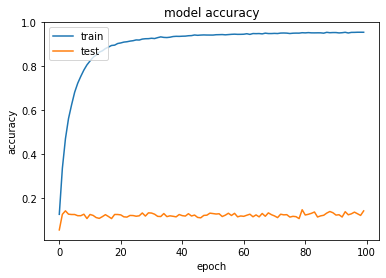

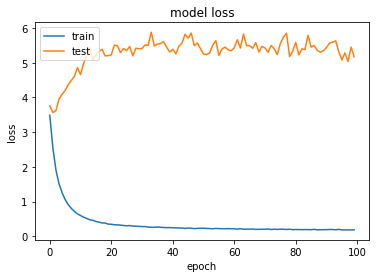

In [27]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

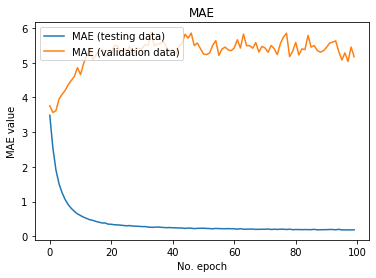

In [28]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

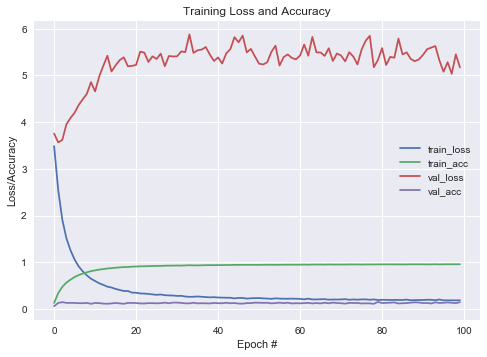

In [29]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2_OF.png')
plt.close()